In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import xarray as xr
import pandas as pd
import h5py
import pycomlink as pycml
import netCDF4
from cycler import cycler

In [3]:
default_cycler = plt.rcParams['axes.prop_cycle']
# print(default_cycler)
# print(default_cycler.by_key()['color'])
# print(np.roll(default_cycler.by_key()['color'],-2))


nrsl_cycler = (cycler(color=np.roll(default_cycler.by_key()['color'],-2)))

def rollcycler(n_advance,_cycler=default_cycler):
    return (cycler(color=np.roll(_cycler.by_key()['color'],-n_advance)))

''' 
takes in two cml wet arrays (e.g. cml.wet and cml.wet_test) and calculates the confusion matrix assuming the first is truth and the second is prediction
'''
def calc_confusion(_truth,_test, _channel_id=0):
    true_pos = (_truth & _test)
    true_neg = (~_truth & ~_test)

    false_pos = ((_truth == 0) & (_test ==1))
    false_neg = ((_truth == 1) & (_test ==0))
    num_true_pos = len(true_pos.isel(channel_id=_channel_id).values.nonzero()[0])
    num_true_neg = len(true_neg.isel(channel_id=_channel_id).values.nonzero()[0])
    num_false_pos = len(false_pos.isel(channel_id=_channel_id).values.nonzero()[0])
    num_false_neg = len(false_neg.isel(channel_id=_channel_id).values.nonzero()[0])

    return true_pos, true_neg, false_pos, false_neg, num_true_pos,num_true_neg,num_false_pos, num_false_neg

# Load example data and do preprocessing

We load the example data from one NetCDF file which contains the time series of 500 CMLs over 10 days. If you want to use your own data, e.g. from a CSV file, look at the respective example notebook for how to get started.

In [4]:
data_path = pycml.io.examples.get_example_data_path()
print(data_path)

cmls = xr.open_dataset(data_path + '/example_cml_data.nc')
cmls

c:\Users\acuddeback\Miniconda3\lib\site-packages\pycomlink\io\example_data


<xarray.Dataset>
Dimensions:           (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) object '0' '1' '2' '3' ... '497' '498' '499'
    length            (cml_id) float64 ...
    site_a_latitude   (cml_id) float64 ...
    site_a_longitude  (cml_id) float64 ...
    site_b_latitude   (cml_id) float64 ...
    site_b_longitude  (cml_id) float64 ...
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 ...
    polarization      (cml_id, channel_id) object ...
Data variables:
    rsl               (channel_id, cml_id, time) float32 ...
    tsl               (channel_id, cml_id, time) float32 ...

# Have a quick look at the data of one CML
We store each CML as item of a list because we want to do the processing per CML.

In the plot, note that there are some outliers. These correspond to fill values, which we get rid of in the next step.

In [5]:
cml_list = [cmls.isel(cml_id=i) for i in range(len(cmls.cml_id))]

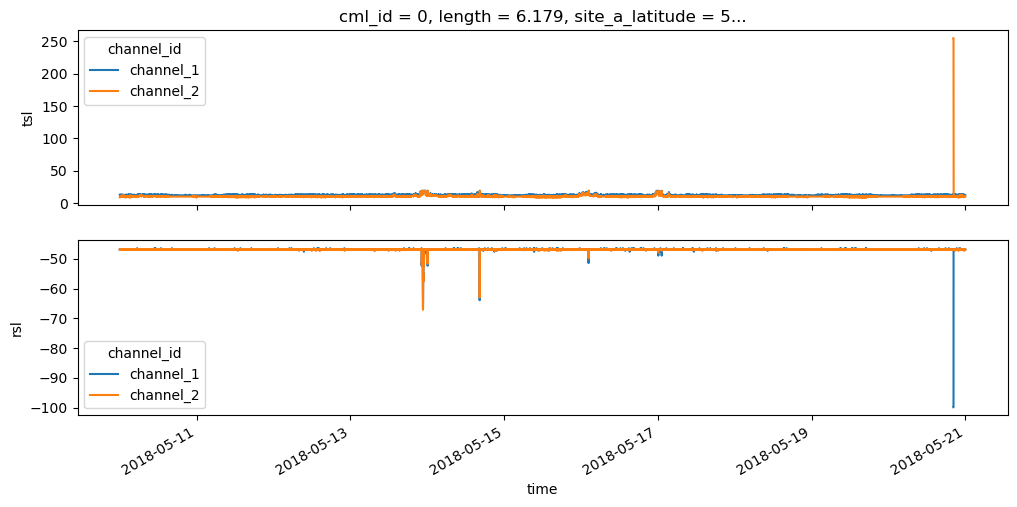

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,5))
cml_list[0].tsl.plot.line(x='time', ax=axs[0])
cml_list[0].rsl.plot.line(x='time', ax=axs[1])
axs[0].set_xlabel('')
axs[1].set_title('');

# Set default and fill values to NaN and calculate TRSL
TRSL is the transmitted signal level minus the received signal level and represents the total path loss along the CML.

In [7]:
# all_tsl_stds = np.zeros((1,len(cml_list)))
# i = 0
for cml in cml_list:
    # cml['tsl_std'] = np.std(cml['tsl']).values
    # all_tsl_stds[i] = np.std(cml['tsl']).values
    cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
    cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
    cml['trsl'] = cml.tsl - cml.rsl
    cml['nrsl'] = -cml.rsl
    cml['tsl_std'] = np.std(cml['tsl']).values

# print(cml_list[0])
# print(cml_list[1])

We can now also see TSL and RSL withouth the fill values that we removed.

Also note that TRSL changes during weak attenuation events stem mostly from TSL changes because this CML has automatic transmission power control (ATPC) which tries to keep RSL constant as long as possible by increasing TSL when path-attenuation occurs.

Text(0.5, 1.0, '')

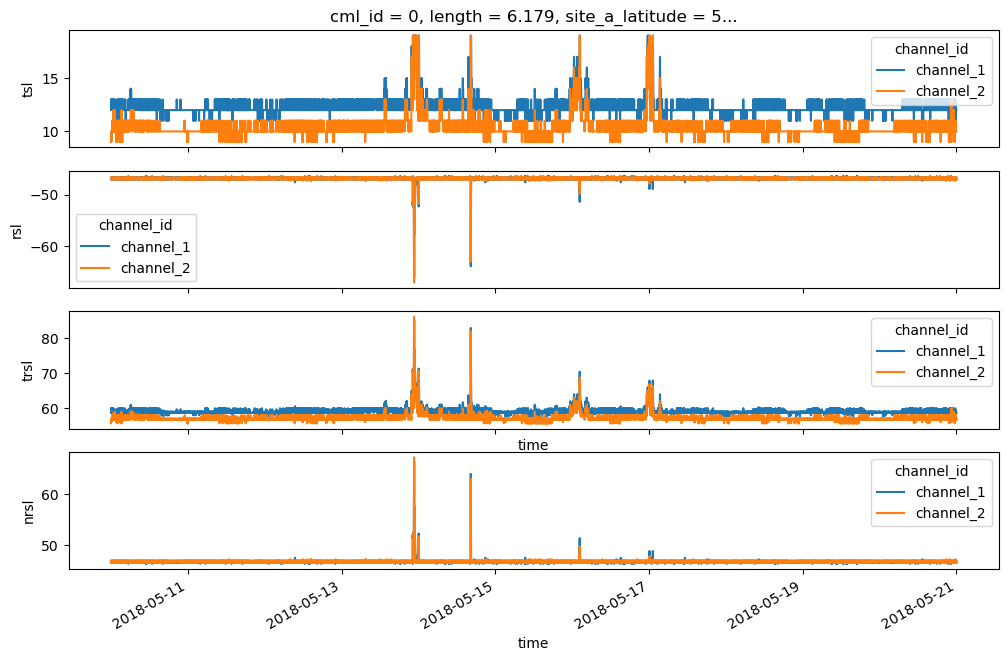

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12,7))
cml_list[0].tsl.plot.line(x='time', ax=axs[0])
cml_list[0].rsl.plot.line(x='time', ax=axs[1])
cml_list[0].trsl.plot.line(x='time', ax=axs[2])
cml_list[0].nrsl.plot.line(x='time', ax=axs[3])
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[1].set_title('')
axs[2].set_title('')
axs[3].set_title('')

# Calculate TSL Standard Deviation 
not all CMLS will have really erratic TSL but we want to know which

In [9]:
all_tsl_stds = np.zeros(len(cml_list))
for i in range(len(cml_list)-1):
    cml = cml_list[i]
    cml['tsl_std'] = np.std(cml['tsl']).values
    all_tsl_stds[i] = np.std(cml['tsl']).values
    all_tsl_stds[i] = cml['tsl_std'].values

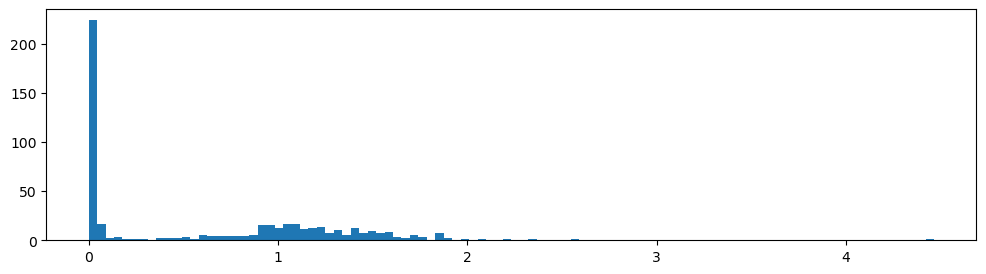

In [10]:
plt.figure(figsize=(12,3))
plt.hist(all_tsl_stds, bins=100)
plt.show()

# Interpolate short gaps in TRSL 

Our CML data might have data gaps. These gaps can stem from outages of the data acuqisition or from blackout gaps. If they stem from a blackout gap, there are better methods than linear interpolation. See the notebook `Blackout gap detection example` for more details.

Here we stick to a simple linear interpolatoin of a maximum gap width of 5 minutes.

In [11]:
for cml in cml_list:
    cml['trsl'] = cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')
    cml['nrsl'] = cml.nrsl.interpolate_na(dim='time', method='linear', max_gap='5min')

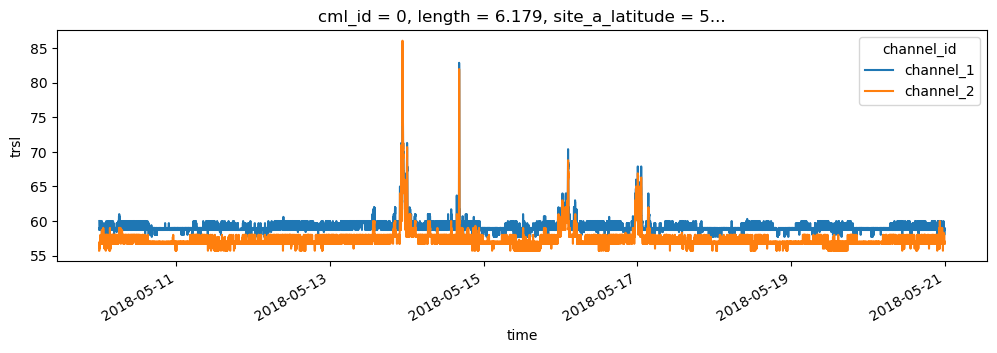

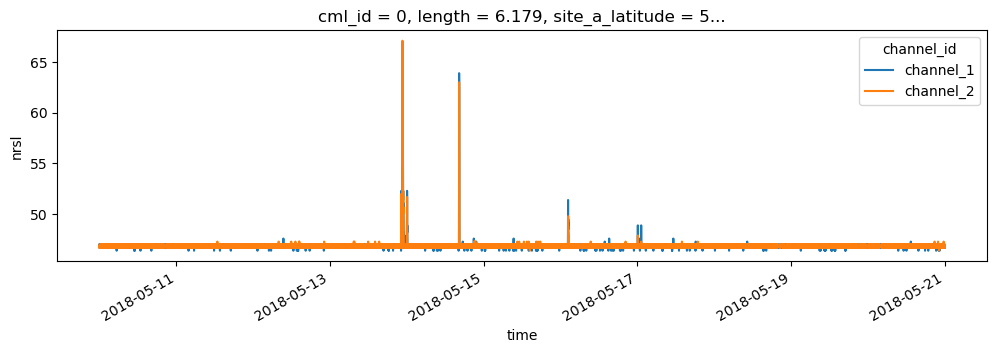

In [12]:
cml = cml_list[0].copy() # make a copy here to not change the CML dataset in the list over which we want to iterate later - picks the single cml from the cml list
cml.trsl.plot.line(x='time', figsize=(12,3));
cml.nrsl.plot.line(x='time', figsize=(12,3));

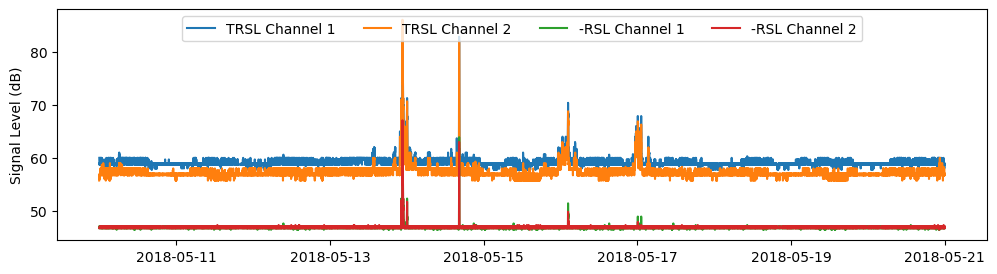

In [13]:
plt.figure(figsize=(12,3))
plt.plot(cml['time'], cml['trsl'][0], label="TRSL Channel 1")
plt.plot(cml['time'], cml['trsl'][1], label="TRSL Channel 2")
plt.plot(cml['time'], cml['nrsl'][0], label="-RSL Channel 1")
plt.plot(cml['time'], cml['nrsl'][1], label="-RSL Channel 2")

plt.ylabel("Signal Level (dB)") 
plt.legend(loc='upper center', ncol=4)

plt.show()

# Do simple wet-dry classification using a rolling standard deviation 

This is the most basic way of doing a wet-dry classification. The crucial part here is to find the optimal threshold. To keep this example short, we use a standard value of 0.8 which is more or less suitable for most CML time series. But please note, that this threshold should be adapted to the noisiness of the individual CML time series, e.g. as in [Graf et al. 2020](https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020.html) to get the good performance for CML rainfall estimation.

In [14]:
threshold = 0.8
threshold_rsl = threshold/np.sqrt(2) 
print(threshold_rsl)

roll_std_dev = cml.trsl.rolling(time=60, center=True).std()
cml['wet'] = cml.trsl.rolling(time=60, center=True).std() > threshold

roll_std_dev_rsl = cml.nrsl.rolling(time=60, center=True).std()
cml['wet_rsl'] = cml.nrsl.rolling(time=60, center=True).std() > threshold_rsl

0.565685424949238


CHANNEL 1 WET EVENTS: <xarray.DataArray 'wet' ()>
array(935)
Coordinates:
    cml_id            <U1 '0'
    length            float64 6.179
    site_a_latitude   float64 58.26
    site_a_longitude  float64 1.388
    site_b_latitude   float64 58.25
    site_b_longitude  float64 1.304
    channel_id        <U9 'channel_1'
    frequency         float64 ...
    polarization      object ...
CHANNEL 1 WET EVENTS: 935


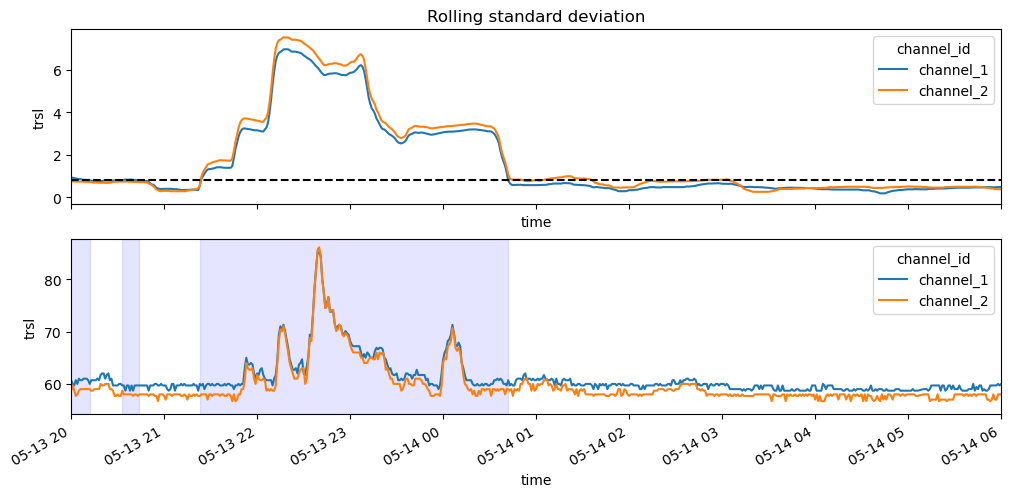

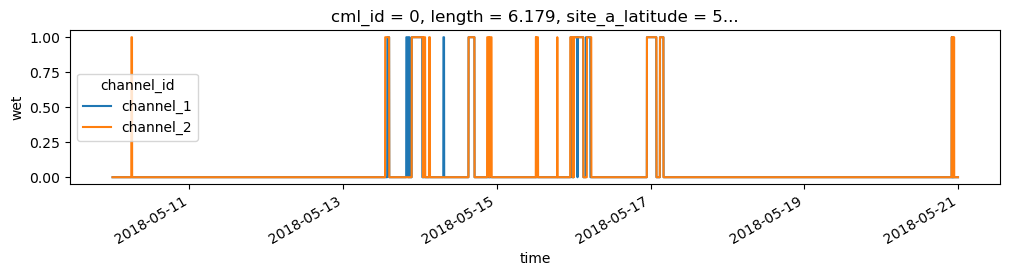

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

roll_std_dev.plot.line(x='time', ax=axs[0]) # standard deviation is from whole CML dataset
# roll_std_dev_rsl.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--')
axs[0].set_title('Rolling standard deviation')

cml.trsl.plot.line(x='time', ax=axs[1]);
# cml.nrsl.plot.line(x='time', ax=axs[1]);


# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet # autocorrelation?
wet_end = np.roll(cml.wet, 1) & ~cml.wet

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.isel(channel_id=0).values.nonzero()[0],
    wet_end.isel(channel_id=0).values.nonzero()[0],
):
    axs[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1,label="wet")
print("CHANNEL 1 WET EVENTS:", np.sum(cml.wet[0]))
print("CHANNEL 1 WET EVENTS:", len(cml.wet.isel(channel_id=0).values.nonzero()[0]))

axs[1].set_title(''); # wet dry is just set on channel 1
axs[1].set_xlim(pd.to_datetime('2018-05-13 20:00:00'), pd.to_datetime('2018-05-14 06:00:00'));

plt.figure(figsize=(12,2))
cml.wet.plot.line(x='time')

CHANNEL 1 WET EVENTS: <xarray.DataArray 'wet' ()>
array(935)
Coordinates:
    cml_id            <U1 '0'
    length            float64 6.179
    site_a_latitude   float64 58.26
    site_a_longitude  float64 1.388
    site_b_latitude   float64 58.25
    site_b_longitude  float64 1.304
    channel_id        <U9 'channel_1'
    frequency         float64 ...
    polarization      object ...
CHANNEL 1 WET EVENTS: 935


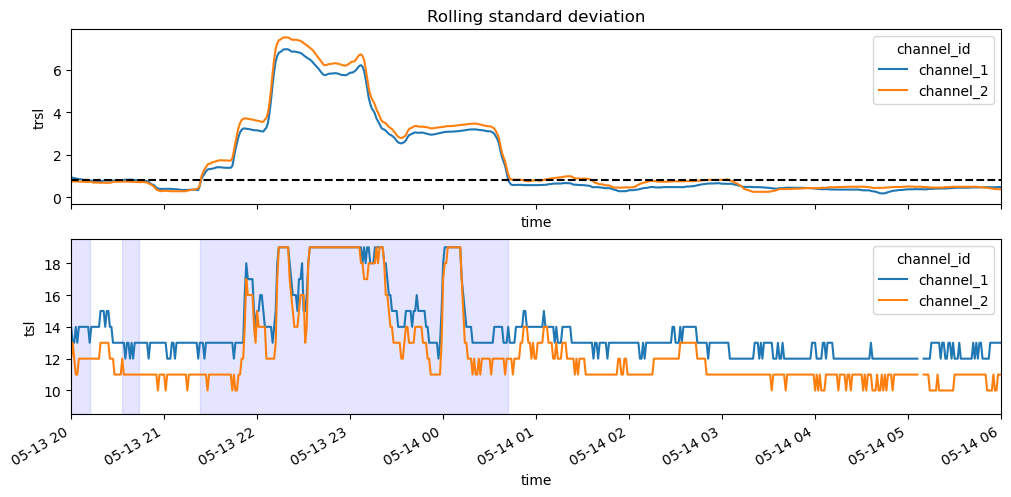

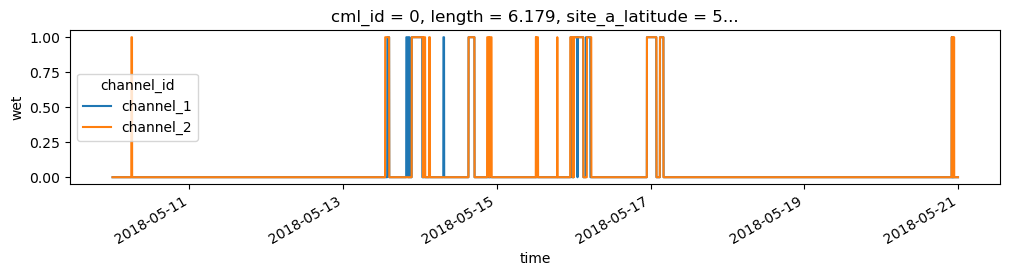

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

roll_std_dev.plot.line(x='time', ax=axs[0]) # standard deviation is from whole CML dataset
# roll_std_dev_rsl.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--')
axs[0].set_title('Rolling standard deviation')

cml.tsl.plot.line(x='time', ax=axs[1]);
# cml.nrsl.plot.line(x='time', ax=axs[1]);

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet # autocorrelation?
wet_end = np.roll(cml.wet, 1) & ~cml.wet

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.isel(channel_id=0).values.nonzero()[0],
    wet_end.isel(channel_id=0).values.nonzero()[0],
):
    axs[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1,label="wet")
print("CHANNEL 1 WET EVENTS:", np.sum(cml.wet[0]))
print("CHANNEL 1 WET EVENTS:", len(cml.wet.isel(channel_id=0).values.nonzero()[0]))

axs[1].set_title(''); # wet dry is just set on channel 1
axs[1].set_xlim(pd.to_datetime('2018-05-13 20:00:00'), pd.to_datetime('2018-05-14 06:00:00'));

plt.figure(figsize=(12,2))
cml.wet.plot.line(x='time')

TOTAL WET EVENTS for no TX 303


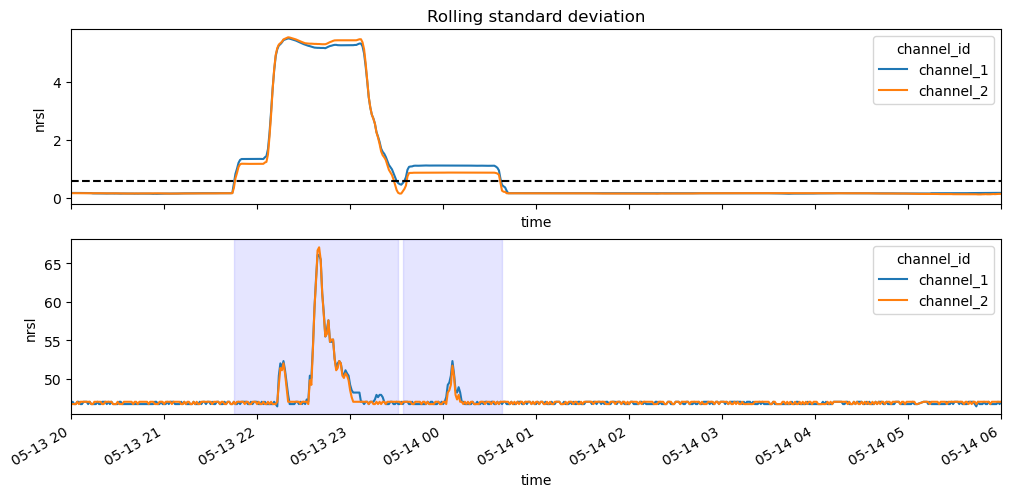

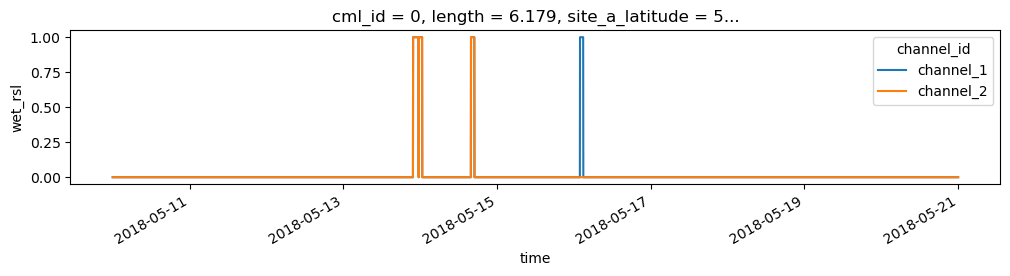

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

roll_std_dev_rsl.plot.line(x='time', ax=axs[0])
# roll_std_dev_rsl.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold_rsl, color='k', linestyle='--')
axs[0].set_title('Rolling standard deviation')

cml.nrsl.plot.line(x='time', ax=axs[1]);
# cml.nrsl.plot.line(x='time', ax=axs[1]);


# Get start and end of dry event
wet_start_rsl = np.roll(cml.wet_rsl, -1) & ~cml.wet_rsl
wet_end_rsl = np.roll(cml.wet_rsl, 1) & ~cml.wet_rsl

sumwet = 0

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start_rsl.isel(channel_id=0).values.nonzero()[0],
    wet_end_rsl.isel(channel_id=0).values.nonzero()[0],
):
    axs[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)
    sumwet = wet_end_i-wet_start_i+1+sumwet
print("TOTAL WET EVENTS for no TX", sumwet)
# axs[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1,label="blue")

axs[1].set_title('');
axs[1].set_xlim(pd.to_datetime('2018-05-13 20:00:00'), pd.to_datetime('2018-05-14 06:00:00'));

plt.figure(figsize=(12,2))
cml.wet_rsl.plot.line(x='time')

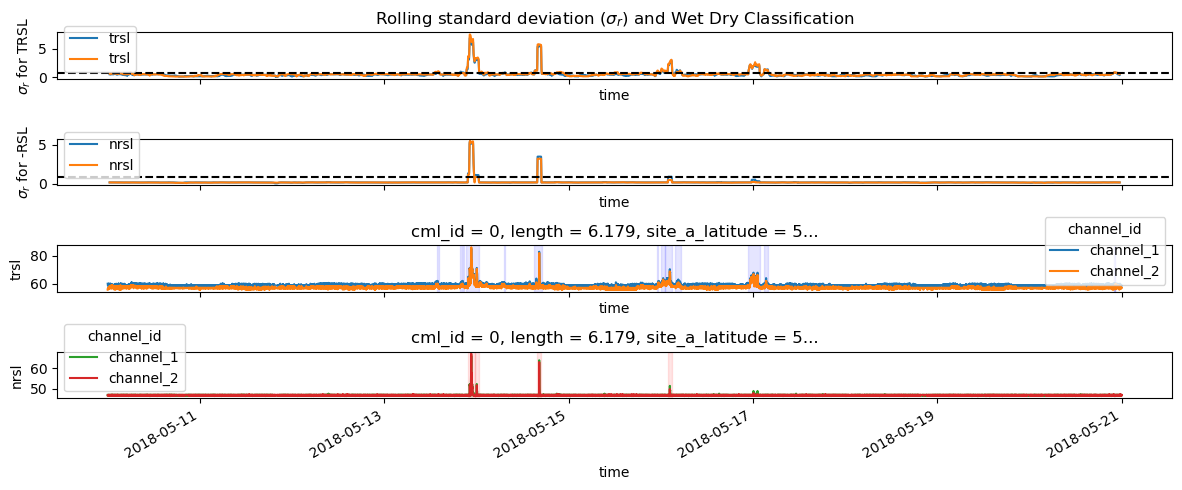

In [18]:
# threshold = 0.8

# roll_std_dev = cml.trsl.rolling(time=60, center=True).std()
# cml['wet'] = roll_std_dev > threshold

# roll_std_dev_rsl = cml.nrsl.rolling(time=60, center=True).std()
# cml['wet_rsl'] = roll_std_dev_rsl > threshold

fig, axs = plt.subplots(4, 1, figsize=(12,5), sharex=True)

roll_std_dev.plot.line(x='time', ax=axs[0], label='trsl')
roll_std_dev_rsl.plot.line(x='time', ax=axs[1], label='nrsl')  # Added line
axs[0].axhline(threshold, color='k', linestyle='--')
axs[0].set_title('Rolling standard deviation ($\sigma_{r}$) and Wet Dry Classification')
axs[0].set_ylabel('$\sigma_{r}$ for TRSL')

# just RSL measurement
axs[1].axhline(threshold, color='k', linestyle='--')
axs[1].set_ylabel('$\sigma_{r}$ for -RSL')

cml.trsl.plot.line(x='time', ax=axs[2], label='trsl')
plt.gca().set_prop_cycle(rollcycler(2))
cml.nrsl.plot.line(x='time', ax=axs[3], label='nrsl')  # Added line

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet
wet_end = np.roll(cml.wet, 1) & ~cml.wet

# Get start and end of dry event for nrsl
wet_start_rsl = np.roll(cml.wet_rsl, -1) & ~cml.wet_rsl
wet_end_rsl = np.roll(cml.wet_rsl, 1) & ~cml.wet_rsl

# Plot shaded area for each wet event for trsl
plt.gca().set_prop_cycle(rollcycler(0))
for wet_start_i, wet_end_i in zip(
    wet_start.isel(channel_id=0).values.nonzero()[0],
    wet_end.isel(channel_id=0).values.nonzero()[0],
):
    axs[2].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)

plt.gca().set_prop_cycle(rollcycler(2))
# Plot shaded area for each wet event for nrsl
for wet_start_i, wet_end_i in zip(
    wet_start_rsl.isel(channel_id=0).values.nonzero()[0],
    wet_end_rsl.isel(channel_id=0).values.nonzero()[0],
):
    axs[3].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='r', alpha=0.1)

axs[1].set_title('')
axs[0].legend()  # Added legend for the first subplot
axs[1].legend()  # Added legend for the second subplot

plt.tight_layout()
plt.show()


# Determine Confusion Matrix for wet-dry classification

In [19]:
# # plt.gca().set_prop_cycle(rollcycler(2))


# plt.figure(figsize=(12,1.5))
# cml.wet.plot.line(x='time')
# cml.wet_rsl.plot.line(x='time')
# plt.legend(['trsl channel 1', 'trsl channel 2', '-rsl channel 1', '-rsl channel 2'], ncol=2, loc='upper right')

# # calculate confusion matrix values 
# true_pos = cml.wet & cml.wet_rsl 
# # print("TRUE POS", np.sum(true_pos[0]), "LEGTH", len(true_pos[0]))

# true_pos, true_neg, false_pos, false_neg, num_true_pos,num_true_neg,num_false_pos, num_false_neg = calc_confusion(cml.wet, cml.wet_rsl, _channel_id=0)
# num_total = num_true_pos+num_true_neg+num_false_pos+ num_false_neg
# num_wet = num_true_pos+num_false_neg
# num_dry = num_true_neg+num_false_pos
# conf_matrix = 100*np.asarray([[num_true_neg,num_false_pos],[num_false_neg,num_true_pos]])/num_total
# print("TP + TN + FP + FN = Total:", num_true_pos,num_true_neg,num_false_pos, num_false_neg, num_true_pos+num_true_neg+num_false_pos+num_false_neg, num_total)


# print(num_wet,"wet +",num_dry,"dry = ",num_wet+num_dry,"total = ", len(cml.wet[0]))

# print("TRUE POS:", num_true_pos)
# # 

# # make confusion matrix plot for channel 1
# plt.figure(figsize=(12,1.5))
# plt.gca().set_prop_cycle(rollcycler(4))
# true_pos[0].plot.line(x='time', label="True Positive")
# true_neg[0].plot.line(x='time', label="True Negative")
# false_pos[0].plot.line(x='time', label="False Positive")
# false_neg[0].plot.line(x='time', label="False Negative")

# plt.ylabel("Truth Value"), plt.title("Confusion Matrix Plot for Channel 1")
# plt.legend()
# plt.show()

# # Plot confusion matrix 
# conf_matrix = 100*np.asarray([[num_true_neg,num_false_pos],[num_false_neg,num_true_pos]])/num_total

# plt.figure()
# # Plotting the confusion matrix
# plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
# plt.colorbar()
# plt.title('Confusion Matrix for Channel 1')
# plt.xlabel('Label without Using TSL')
# plt.ylabel('Label Using TSL')
# plt.xticks(np.arange(2), ['Negative', 'Positive'])
# plt.yticks(np.arange(2), ['Negative', 'Positive'])

# # Adding text annotations
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         plt.text(j, i, '{:.2f}%'.format(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')

# plt.show()

# # calculate performance metrics
# Accuracy = (num_true_pos+num_true_neg)/(num_total)
# Precision = (num_true_pos)/(num_true_pos+num_false_pos)
# Sensitivity = (num_true_pos)/(num_true_pos+num_false_neg)
# Specificity = (num_true_neg)/(num_true_neg+num_false_pos)
# F1_Score = (2*Precision*Sensitivity)/(Precision+Sensitivity)
# print("Accuracy:", Accuracy)
# print("Precision:", Precision)
# print("Sensitivity:", Sensitivity)
# print("Specificity:", Specificity)
# print("F1 Score", F1_Score)

In [20]:
# # plt.gca().set_prop_cycle(rollcycler(2))


# plt.figure(figsize=(12,1.5))
# cml.wet.plot.line(x='time')
# cml.wet_rsl.plot.line(x='time')
# plt.legend(['trsl channel 1', 'trsl channel 2', '-rsl channel 1', '-rsl channel 2'], ncol=2, loc='upper right')

# # calculate confusion matrix values 
# true_pos = cml.wet & cml.wet_rsl 
# # print("TRUE POS", np.sum(true_pos[0]), "LEGTH", len(true_pos[0]))

# true_pos, true_neg, false_pos, false_neg, num_true_pos,num_true_neg,num_false_pos, num_false_neg = calc_confusion(cml.wet, cml.wet_rsl, _channel_id=1)
# num_total = num_true_pos+num_true_neg+num_false_pos+ num_false_neg
# num_wet = num_true_pos+num_false_neg
# num_dry = num_true_neg+num_false_pos

# print("TP + TN + FP + FN = Total:", num_true_pos,num_true_neg,num_false_pos, num_false_neg, num_true_pos+num_true_neg+num_false_pos+num_false_neg, num_total)


# print(num_wet,"wet +",num_dry,"dry = ",num_wet+num_dry,"total = ", len(cml.wet[0]))

# print("TRUE POS:", num_true_pos)
# # 

# # make confusion matrix plot for channel 1
# plt.figure(figsize=(12,1.5))
# plt.gca().set_prop_cycle(rollcycler(4))
# true_pos[0].plot.line(x='time', label="True Positive")
# true_neg[0].plot.line(x='time', label="True Negative")
# false_pos[0].plot.line(x='time', label="False Positive")
# false_neg[0].plot.line(x='time', label="False Negative")

# plt.ylabel("Truth Value"), plt.title("Confusion Matrix Plot for Channel 2")
# plt.legend()
# plt.show()


# # make confusion matrix plot for channel 2
# plt.figure(figsize=(12,1.5))
# plt.gca().set_prop_cycle(rollcycler(4))
# true_pos[0].plot.line(x='time', label="True Positive")
# true_neg[0].plot.line(x='time', label="True Negative")
# false_pos[0].plot.line(x='time', label="False Positive")
# false_neg[0].plot.line(x='time', label="False Negative")

# plt.ylabel("Truth Value"), plt.title("Confusion Matrix Plot for Channel 1")
# plt.legend()
# plt.show()

# # Plot confusion matrix 
# conf_matrix = 100*np.asarray([[num_true_neg,num_false_pos],[num_false_neg,num_true_pos]])/num_total

# plt.figure()
# # Plotting the confusion matrix
# plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
# plt.colorbar()
# plt.title('Confusion Matrix for Channel 1')
# plt.xlabel('Label without Using TSL')
# plt.ylabel('Label Using TSL')
# plt.xticks(np.arange(2), ['Negative', 'Positive'])
# plt.yticks(np.arange(2), ['Negative', 'Positive'])

# # Adding text annotations
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         plt.text(j, i, '{:.2f}%'.format(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')

# plt.show()

# # calculate performance metrics
# Accuracy = (num_true_pos+num_true_neg)/(num_total)
# Precision = (num_true_pos)/(num_true_pos+num_false_pos)
# Sensitivity = (num_true_pos)/(num_true_pos+num_false_neg)
# Specificity = (num_true_neg)/(num_true_neg+num_false_pos)
# F1_Score = (2*Precision*Sensitivity)/(Precision+Sensitivity)
# print("Accuracy:", Accuracy)
# print("Precision:", Precision)
# print("Sensitivity:", Sensitivity)
# print("Specificity:", Specificity)
# print("F1 Score", F1_Score)

In [21]:
# # plt.gca().set_prop_cycle(rollcycler(2))


# plt.figure(figsize=(12,1.5))
# cml.wet.plot.line(x='time')
# cml.wet_rsl.plot.line(x='time')
# plt.legend(['trsl channel 1', 'trsl channel 2', '-rsl channel 1', '-rsl channel 2'], ncol=2, loc='upper right')

# # calculate confusion matrix values 
# true_pos = cml.wet & cml.wet_rsl 
# # print("TRUE POS", np.sum(true_pos[0]), "LEGTH", len(true_pos[0]))

# true_pos, true_neg, false_pos, false_neg, num_true_pos,num_true_neg,num_false_pos, num_false_neg = calc_confusion(cml.wet, cml.wet_rsl, _channel_id=1)
# num_total = num_true_pos+num_true_neg+num_false_pos+ num_false_neg
# num_wet = num_true_pos+num_false_neg
# num_dry = num_true_neg+num_false_pos

# print("TP + TN + FP + FN = Total:", num_true_pos,num_true_neg,num_false_pos, num_false_neg, num_true_pos+num_true_neg+num_false_pos+num_false_neg, num_total)


# print(num_wet,"wet +",num_dry,"dry = ",num_wet+num_dry,"total = ", len(cml.wet[0]))

# print("TRUE POS:", num_true_pos)
# # 

# # make confusion matrix plot for channel 1
# plt.figure(figsize=(12,1.5))
# plt.gca().set_prop_cycle(rollcycler(4))
# true_pos[0].plot.line(x='time', label="True Positive")
# true_neg[0].plot.line(x='time', label="True Negative")
# false_pos[0].plot.line(x='time', label="False Positive")
# false_neg[0].plot.line(x='time', label="False Negative")

# plt.ylabel("Truth Value"), plt.title("Confusion Matrix Plot for Channel 2")
# plt.legend()
# plt.show()


# # make confusion matrix plot for channel 2
# plt.figure(figsize=(12,1.5))
# plt.gca().set_prop_cycle(rollcycler(4))
# true_pos[0].plot.line(x='time', label="True Positive")
# true_neg[0].plot.line(x='time', label="True Negative")
# false_pos[0].plot.line(x='time', label="False Positive")
# false_neg[0].plot.line(x='time', label="False Negative")

# plt.ylabel("Truth Value"), plt.title("Confusion Matrix Plot for Channel 1")
# plt.legend()
# plt.show()

# # Plot confusion matrix 
# conf_matrix = 100*np.asarray([[num_true_neg,num_false_pos],[num_false_neg,num_true_pos]])/num_total

# plt.figure()
# # Plotting the confusion matrix
# plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
# plt.colorbar()
# plt.title('Confusion Matrix for Channel 1')
# plt.xlabel('Label without Using TSL')
# plt.ylabel('Label Using TSL')
# plt.xticks(np.arange(2), ['Negative', 'Positive'])
# plt.yticks(np.arange(2), ['Negative', 'Positive'])

# # Adding text annotations
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         plt.text(j, i, '{:.2f}%'.format(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')

# plt.show()

# # calculate performance metrics
# Accuracy = (num_true_pos+num_true_neg)/(num_total)
# Precision = (num_true_pos)/(num_true_pos+num_false_pos)
# Sensitivity = (num_true_pos)/(num_true_pos+num_false_neg)
# Specificity = (num_true_neg)/(num_true_neg+num_false_pos)
# F1_Score = (2*Precision*Sensitivity)/(Precision+Sensitivity)
# print("Accuracy:", Accuracy)
# print("Precision:", Precision)
# print("Sensitivity:", Sensitivity)
# print("Specificity:", Specificity)
# print("F1 Score", F1_Score)

# Determine baseline

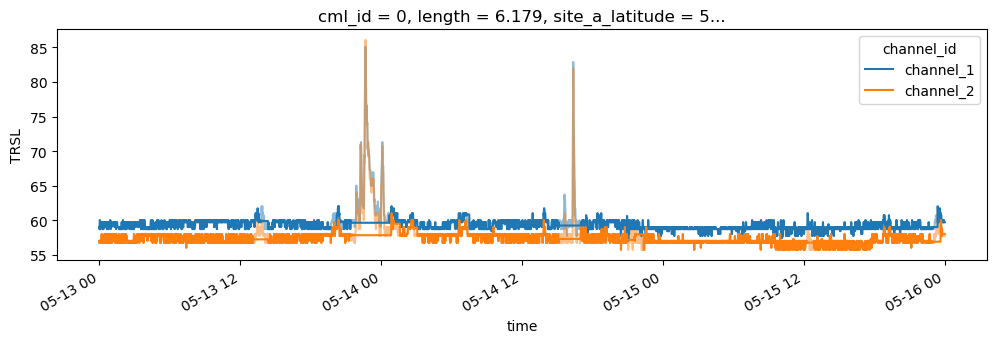

In [22]:
cml['baseline'] = pycml.processing.baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet, n_average_last_dry=5)

fig, ax = plt.subplots(figsize=(12,3))

cml.trsl.sel(time=slice('2018-05-13', '2018-05-15')).plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)
cml.baseline.sel(time=slice('2018-05-13', '2018-05-15')).plot.line(x='time');
plt.gca().set_prop_cycle(None)
plt.ylabel('TRSL');

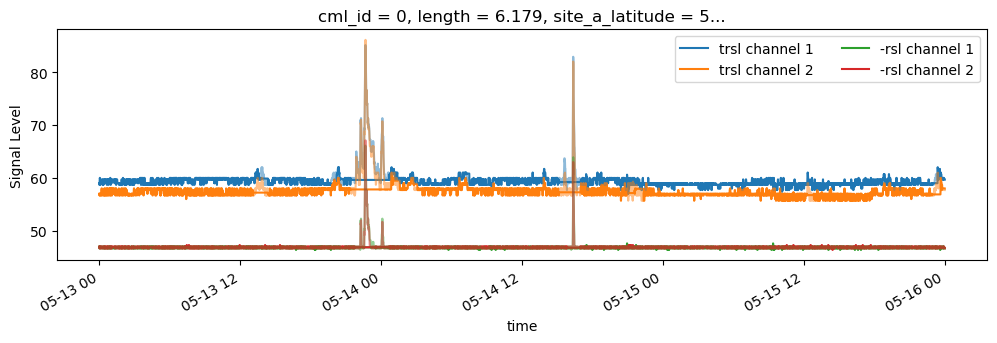

In [23]:
cml['baseline'] = pycml.processing.baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet, n_average_last_dry=5)
cml['baseline_rsl'] = pycml.processing.baseline.baseline_constant(trsl=cml.nrsl, wet=cml.wet_rsl, n_average_last_dry=5)


fig, ax = plt.subplots(figsize=(12,3))

cml.baseline.sel(time=slice('2018-05-13', '2018-05-15')).plot.line(x='time');
cml.baseline_rsl.sel(time=slice('2018-05-13', '2018-05-15')).plot.line(x='time');
plt.gca().set_prop_cycle(None)

cml.trsl.sel(time=slice('2018-05-13', '2018-05-15')).plot.line(x='time', alpha=0.5, label='trsl')
cml.nrsl.sel(time=slice('2018-05-13', '2018-05-15')).plot.line(x='time', alpha=0.5, label='rsl')
plt.gca().set_prop_cycle(None)

plt.legend(['trsl channel 1', 'trsl channel 2', '-rsl channel 1', '-rsl channel 2'], ncol=2, loc='upper right')

plt.ylabel('Signal Level');

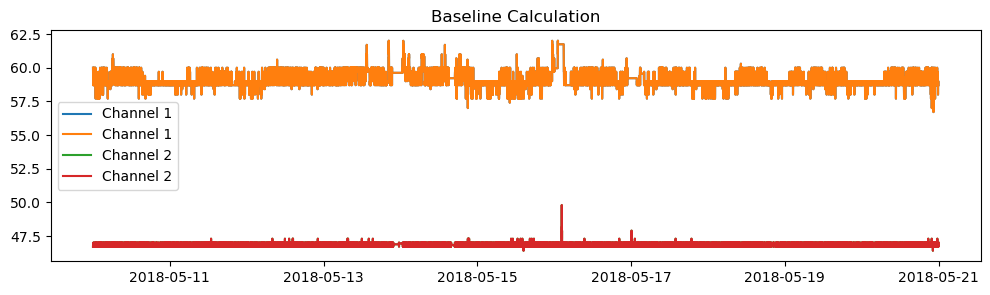

In [24]:
plt.figure(figsize=(12,3))
plt.plot(cml['time'], cml['baseline'][0], label="Channel 1")
plt.plot(cml['time'], cml['baseline'][0], label="Channel 1")
plt.plot(cml['time'], cml['baseline_rsl'][1], label="Channel 2")
plt.plot(cml['time'], cml['baseline_rsl'][1], label="Channel 2")
plt.title("Baseline Calculation")
plt.legend()
plt.show()

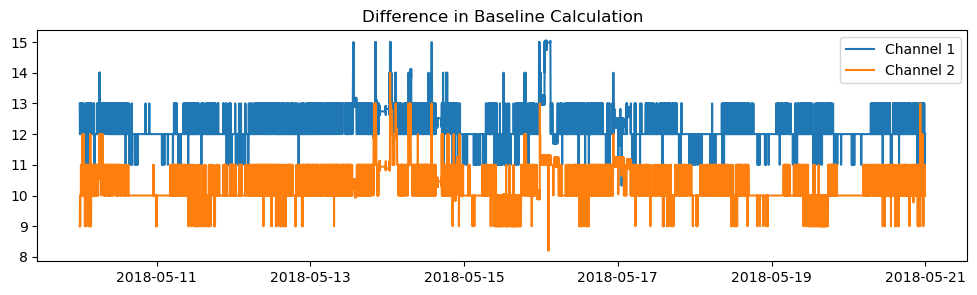

In [25]:
plt.figure(figsize=(12,3))
plt.plot(cml['time'], cml['baseline'][0]-cml['baseline_rsl'][0], label="Channel 1")
plt.plot(cml['time'], cml['baseline'][1]-cml['baseline_rsl'][1], label="Channel 2")
plt.title("Difference in Baseline Calculation")
plt.legend()
plt.show()

# Perform wet antenna estimation and compare to uncorrected baseline 

In [26]:
cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline, 
    wet=cml.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

cml['waa_rsl'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=-cml.rsl, 
    baseline=cml.baseline_rsl, 
    wet=cml.wet_rsl, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

Text(0.5, 1.0, '')

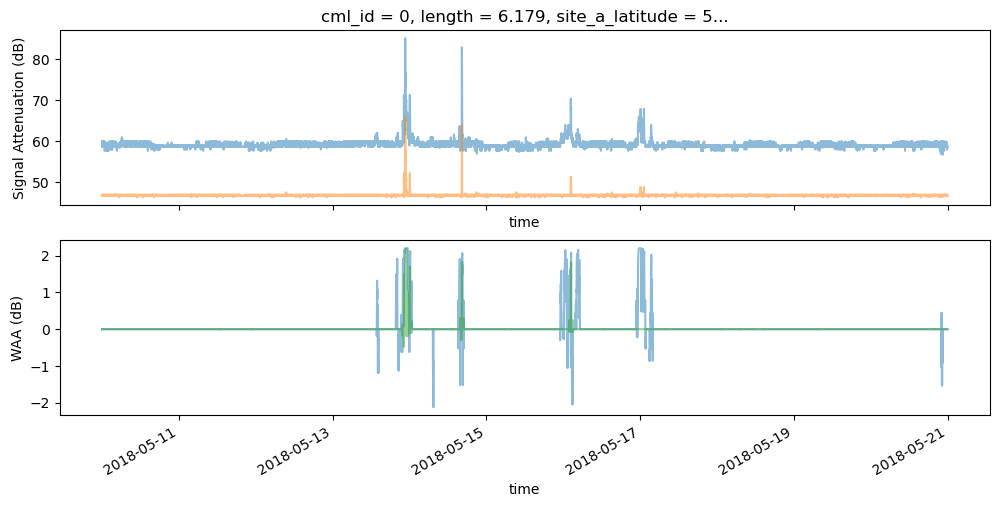

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)
cml.isel(channel_id=0).trsl.plot.line(x='time', alpha=0.5, label='TRSL',ax=axs[0])
plt.gca().set_prop_cycle(nrsl_cycler)

cml.isel(channel_id=0).nrsl.plot.line(x='time', alpha=0.5, label='-RSL',ax=axs[0])
axs[0].set_ylabel("Signal Attenuation (dB)")
plt.gca().set_prop_cycle(None)
cml.isel(channel_id=0).waa.plot.line(x='time', alpha=0.5, label='TRSL',ax=axs[1])
plt.gca().set_prop_cycle(nrsl_cycler)
cml.isel(channel_id=0).waa_rsl.plot.line(x='time', alpha=0.5, label='-RSL',ax=axs[1])
axs[1].set_ylabel("WAA (dB)")
axs[1].set_title("")

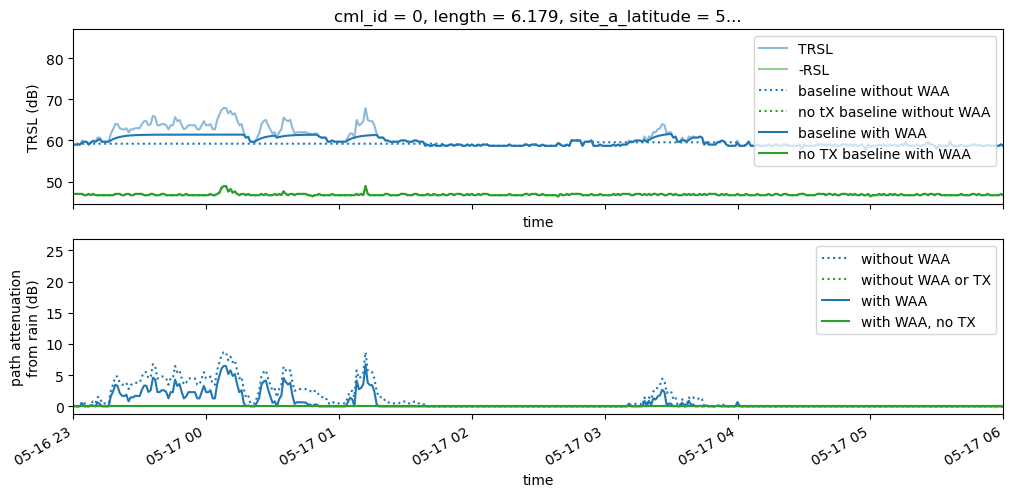

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

plt.sca(axs[0])
cml.isel(channel_id=0).trsl.plot.line(x='time', alpha=0.5, label='TRSL')
plt.gca().set_prop_cycle(nrsl_cycler)
cml.isel(channel_id=0).nrsl.plot.line(x='time', alpha=0.5, label='-RSL')
plt.gca().set_prop_cycle(None)

cml.isel(channel_id=0).baseline.plot.line(x='time', linestyle=':', label='baseline without WAA');
plt.gca().set_prop_cycle(nrsl_cycler)
cml.isel(channel_id=0).baseline_rsl.plot.line(x='time', linestyle=':', label='no tX baseline without WAA');
plt.gca().set_prop_cycle(None)
(cml.baseline + cml.waa).isel(channel_id=0).plot.line(x='time', label='baseline with WAA');
plt.gca().set_prop_cycle(nrsl_cycler)
(cml.baseline_rsl + cml.waa_rsl).isel(channel_id=0).plot.line(x='time', label='no TX baseline with WAA');
plt.ylabel('TRSL (dB)')

axs[0].legend()

# estimate WAA and correct baseline
cml['A'] = cml.trsl - cml.baseline - cml.waa
cml['A'].values[cml.A < 0] = 0
cml['A_no_waa_correct'] = cml.trsl - cml.baseline
cml['A_no_waa_correct'].values[cml.A_no_waa_correct < 0] = 0

# estimate WAA and correct baseline
cml['A_rsl'] = cml.nrsl - cml.baseline_rsl - cml.waa_rsl
cml['A_rsl'].values[cml.A_rsl < 0] = 0
cml['A_no_waa_correct_rsl'] = cml.nrsl - cml.baseline_rsl
cml['A_no_waa_correct_rsl'].values[cml.A_no_waa_correct_rsl < 0] = 0


plt.sca(axs[1])
cml.A_no_waa_correct.isel(channel_id=0).plot.line(x='time', linestyle=':', label='without WAA');
plt.gca().set_prop_cycle(nrsl_cycler)
cml.A_no_waa_correct_rsl.isel(channel_id=0).plot.line(x='time', linestyle=':', label='without WAA or TX');
plt.gca().set_prop_cycle(None)
cml.A.isel(channel_id=0).plot.line(x='time', label='with WAA');
plt.gca().set_prop_cycle(nrsl_cycler)
cml.A_rsl.isel(channel_id=0).plot.line(x='time', label='with WAA, no TX');
plt.ylabel('path attenuation\nfrom rain (dB)');
axs[1].set_title('');
axs[1].legend()
# axs[1].set_xlim(pd.to_datetime('2018-05-13 20:00:00'), pd.to_datetime('2018-05-15 01:00:00'));
axs[1].set_xlim(pd.to_datetime('2018-05-16 23:00:00'), pd.to_datetime('2018-05-17 06:00:00'));

# Calculate rain rate

In [29]:
cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cml.A, L_km=float(cml.length), 
    f_GHz=cml.frequency/1e9, 
    pol=cml.polarization
)
# cml['R_rsl'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A_rsl, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization)
cml['R_rsl'] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cml.A_rsl, 
    L_km=float(cml.length), 
    f_GHz=cml.frequency/1e9, 
    pol=cml.polarization
)

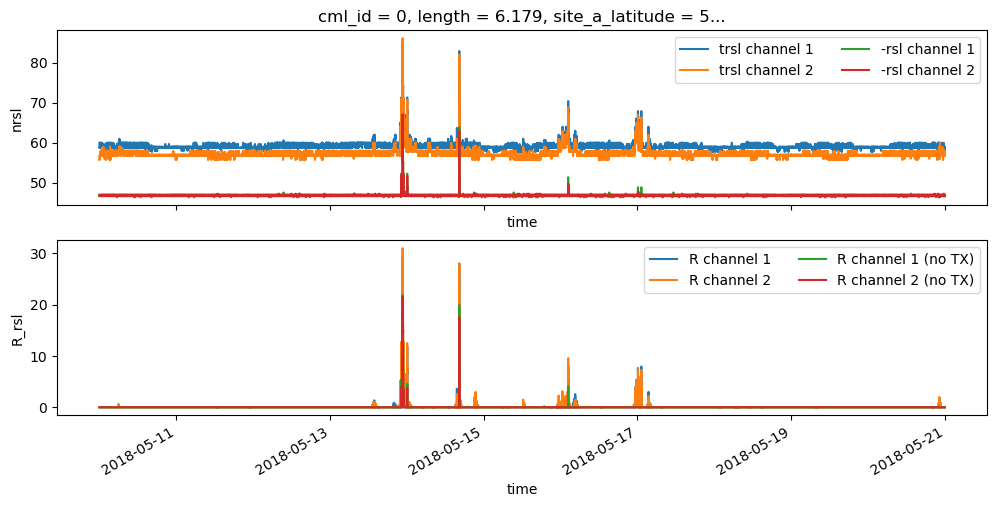

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)
cml.trsl.plot.line(x='time', ax=axs[0])
cml.nrsl.plot.line(x='time', ax=axs[0])
cml.R.plot.line(x='time', ax=axs[1])
cml.R_rsl.plot.line(x='time', ax=axs[1])

axs[0].legend(['trsl channel 1', 'trsl channel 2', '-rsl channel 1', '-rsl channel 2'], ncol=2, loc='upper right')
axs[1].legend(['R channel 1', 'R channel 2', 'R channel 1 (no TX)', 'R channel 2 (no TX)'], ncol=2, loc='upper right')
axs[1].set_title('');

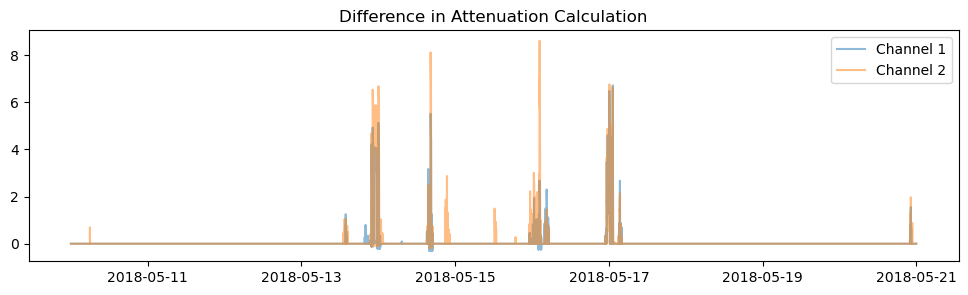

In [31]:
plt.figure(figsize=(12,3))
plt.plot(cml['time'], cml['A'][0]-cml['A_no_waa_correct_rsl'][0], label="Channel 1", alpha=0.5)
plt.plot(cml['time'], cml['A'][1]-cml['A_no_waa_correct_rsl'][1], label="Channel 2", alpha=0.5)
plt.title("Difference in Attenuation Calculation")
plt.legend()
plt.show()

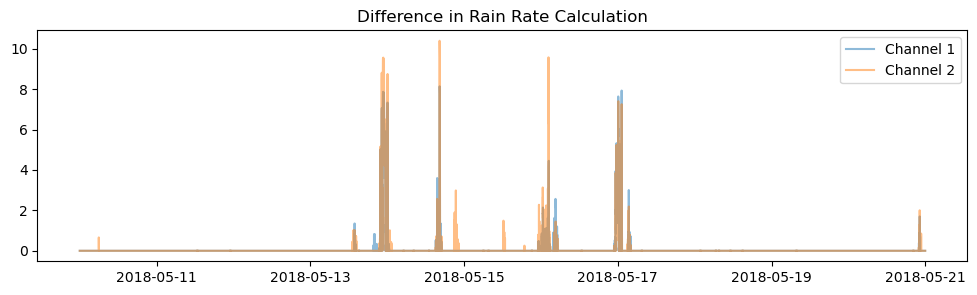

In [32]:
plt.figure(figsize=(12,3))
plt.plot(cml['time'], cml['R'][0]-cml['R_rsl'][0], label="Channel 1", alpha=0.5)
plt.plot(cml['time'], cml['R'][1]-cml['R_rsl'][1], label="Channel 2", alpha=0.5)
plt.title("Difference in Rain Rate Calculation")
plt.legend()
plt.show()

# Now do the whole processing for all CMLs 

In [33]:
cml_abbrev_list = cml_list[0:500].copy()
std_and_conf = np.zeros((500,9))
tslR_diff_nrslR = np.zeros((500,4)) # column 0 is trslR, column 1 is nrslR, column2 is trslR-nrslR # do the mean
for cml, i in zip(tqdm.tqdm(cml_abbrev_list), range(500)):
    cml['nrsl'] = -cml.rsl
    cml['nrsl'] = cml.nrsl.interpolate_na(dim='time', method='linear', max_gap='5min')

    cml['wet'] = cml.trsl.rolling(time=60, center=True).std(skipna=False) > 0.8
    cml['wet_rsl'] = cml.nrsl.rolling(time=60, center=True).std(skipna=False) > threshold_rsl
    
    cml['wet_fraction'] = (cml.wet==1).sum() / len(cml.time)
    cml['wet_fraction_rsl'] = (cml.wet_rsl==1).sum() / len(cml.time)

    # cml['tsl_std'] = np.std(cml.tsl)
    
    cml['baseline'] = pycml.processing.baseline.baseline_constant(
        trsl=cml.trsl, 
        wet=cml.wet, 
        n_average_last_dry=5,
    )

    cml['baseline_rsl'] = pycml.processing.baseline.baseline_constant(
        trsl=cml.nrsl, wet=cml.wet_rsl, n_average_last_dry=5
    )

    cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
        rsl=cml.trsl, 
        baseline=cml.baseline, 
        wet=cml.wet, 
        waa_max=2.2, 
        delta_t=1, 
        tau=15,
    )

    cml['waa_rsl'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.baseline_rsl-cml.rsl, 
    baseline=cml.baseline_rsl, 
    wet=cml.wet_rsl, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
    )
    cml['A'] = cml.trsl - cml.baseline - cml.waa
    
    # Note that we set A < 0 to 0 here, but it is not strictly required for 
    # the next step, because calc_R_from_A sets all rainfall rates below 
    # a certain threshold (default is 0.1) to 0. Some people might want to
    # keep A as it is to check later if there were negative numbers.
    cml['A'].values[cml.A < 0] = 0
    
    cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization
    )
    
    # Wet antenna attenuation increase baseline too much
    cml['A_no_waa_correct_rsl'] = cml.nrsl - cml.baseline_rsl
    cml['A_no_waa_correct_rsl'].values[cml.A_no_waa_correct_rsl < 0] = 0
    cml['R_rsl'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A_no_waa_correct_rsl, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization)
    
    tslR_diff_nrslR[i,0] = np.mean(cml['R'].values[0])
    tslR_diff_nrslR[i,1] = np.mean(cml['R_rsl'].values[0])
    tslR_diff_nrslR[i,2] = np.sqrt(np.mean((cml['R'].values[0] - cml['R_rsl'].values[0])**2)) #RMSE
    tslR_diff_nrslR[i,3] = np.mean(cml['R'].values[0] - cml['R_rsl'].values[0]) # mean difference - shows which is usually larger
    
    std_and_conf[i,0] = cml['tsl_std']
    # Calculate wet-dry confusion matrix for channel 1
    true_pos, true_neg, false_pos, false_neg, num_true_pos,num_true_neg,num_false_pos, num_false_neg = calc_confusion(
        cml.wet, cml.wet_rsl, _channel_id=0
        )
    num_total = num_true_pos+num_true_neg+num_false_pos+ num_false_neg
    num_wet = num_true_pos+num_false_neg
    num_dry = num_true_neg+num_false_pos

    if((num_true_pos+num_false_neg) == 0):
        true_pos_rate = np.nan
        false_neg_rate = np.nan
    else:
        true_pos_rate = num_true_pos/(num_true_pos+num_false_neg)
        false_neg_rate = num_false_neg/(num_true_pos+num_false_neg)
    if((num_true_neg+num_false_pos) == 0):
        true_neg_rate = np.nan
        false_pos_rate = np.nan
    else:
        true_neg_rate = num_true_neg/(num_true_neg+num_false_pos)
        false_pos_rate = num_false_pos/(num_true_neg+num_false_pos)
    

    conf_matrix = 100*np.asarray([[true_neg_rate,false_pos_rate, false_neg_rate,true_pos_rate]])
    
    std_and_conf[i,1:5] = conf_matrix

    true_pos, true_neg, false_pos, false_neg, num_true_pos,num_true_neg,num_false_pos, num_false_neg = calc_confusion(
        cml.wet, cml.wet_rsl, _channel_id=1
        )
    num_total = num_true_pos+num_true_neg+num_false_pos+ num_false_neg
    num_wet = num_true_pos+num_false_neg
    num_dry = num_true_neg+num_false_pos


    if((num_true_pos+num_false_neg) == 0):
        true_pos_rate = np.nan
        false_neg_rate = np.nan
    else:
        true_pos_rate = num_true_pos/(num_true_pos+num_false_neg)
        false_neg_rate = num_false_neg/(num_true_pos+num_false_neg)
    if((num_true_neg+num_false_pos) == 0):
        true_neg_rate = np.nan
        false_pos_rate = np.nan
    else:
        true_neg_rate = num_true_neg/(num_true_neg+num_false_pos)
        false_pos_rate = num_false_pos/(num_true_neg+num_false_pos)

    conf_matrix = 100*np.asarray([[true_neg_rate,false_pos_rate, false_neg_rate,true_pos_rate]])
    
    std_and_conf[1,5:10] = conf_matrix

100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


# Find CMLs that show erratic behavior
Find the CMLs that have a very high ratio of wet/dry data. For the 10-day dataset that is used here and for central-European climate, a ratio higher than 0.3 can be considered very unlikely, i.e. it is unlikely that it was rainy for 30% of the one-minute data points within the 10-day period.

For the plots below, we use a higher threshold 0.8 to only plot a small number of CMLs, but find those that show very strong erratic behavior during dry periods.

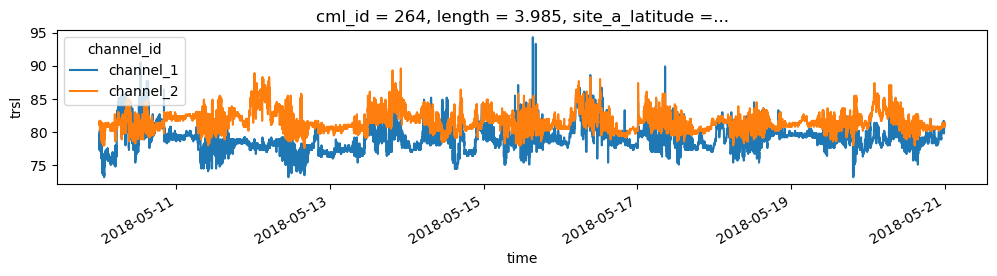

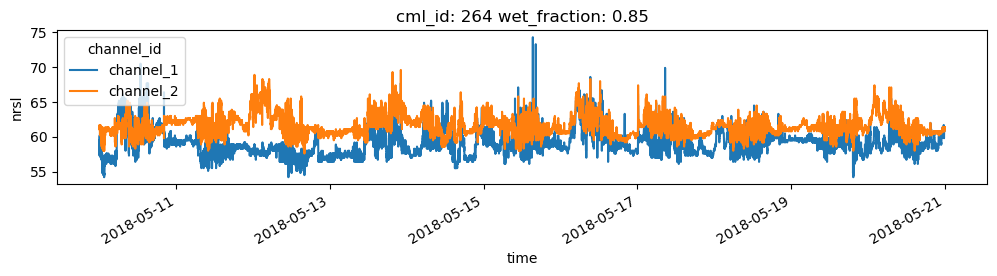

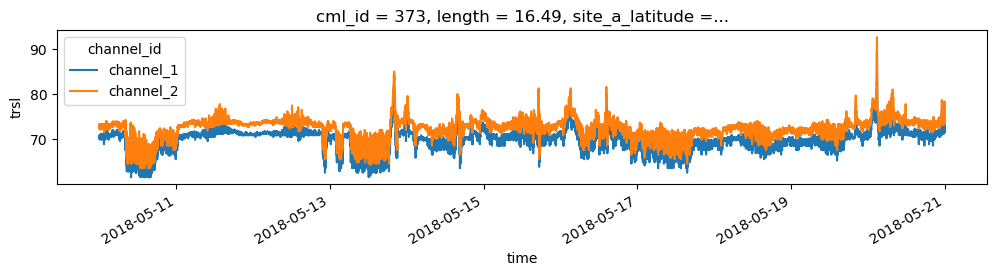

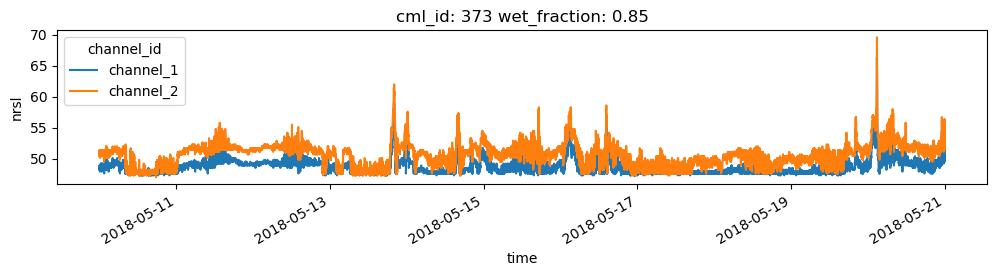

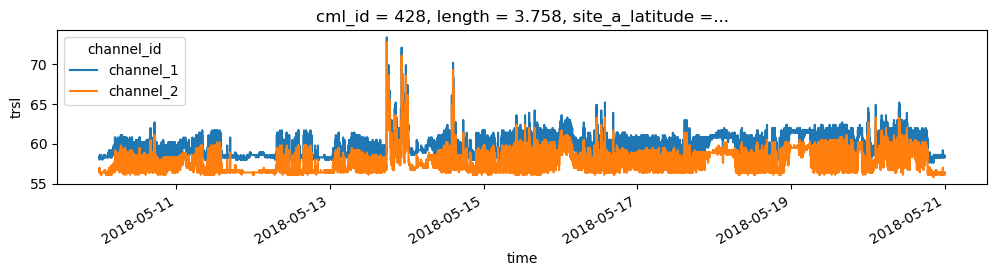

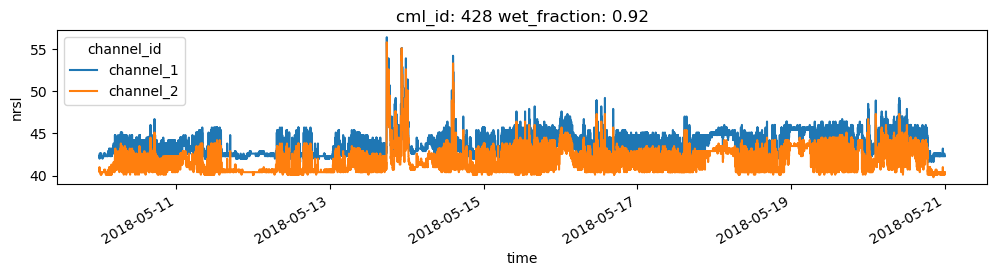

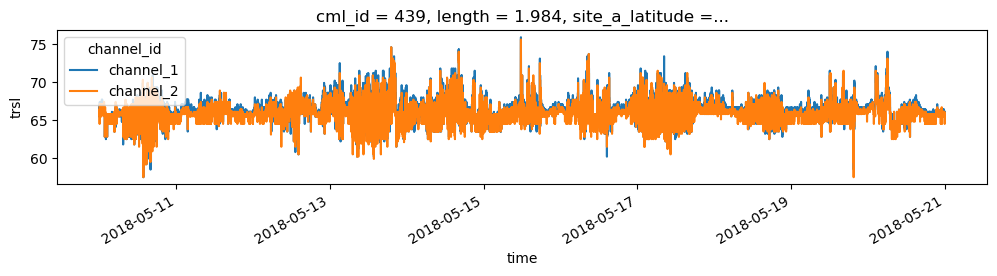

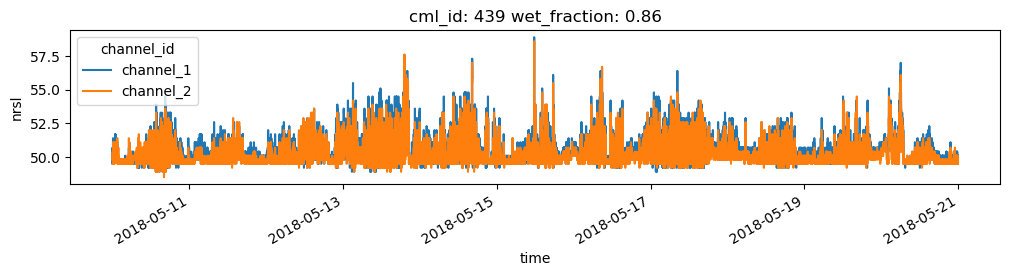

In [34]:
for cml in cml_list:
    if cml.wet_fraction > 0.8:
        cml.trsl.plot.line(x='time', figsize=(12,2))
        plt.gca().set_prop_cycle(rollcycler(2))
        cml.nrsl.plot.line(x='time', figsize=(12,2))
        plt.title(f'cml_id: {cml.cml_id.values} wet_fraction: {cml.wet_fraction.values:0.2f}')
        plt.show()

# Find CMLs with highly variable TSL

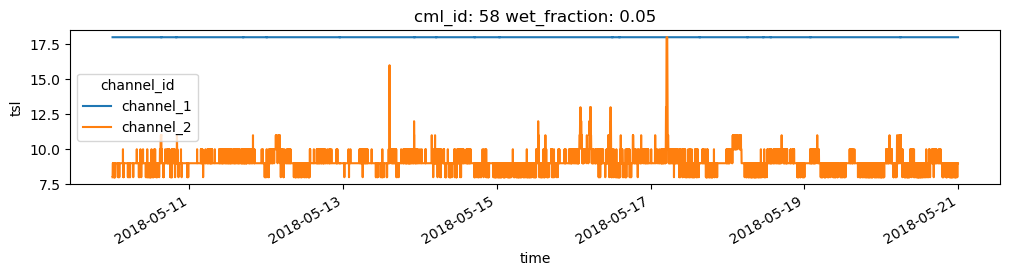

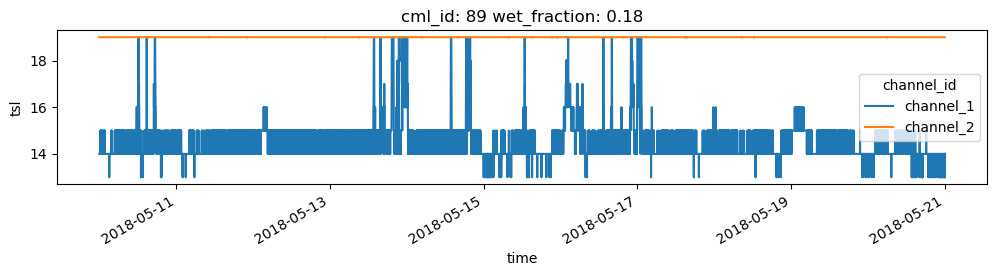

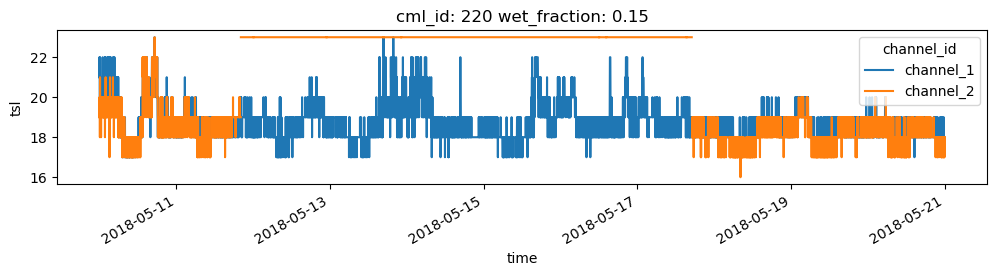

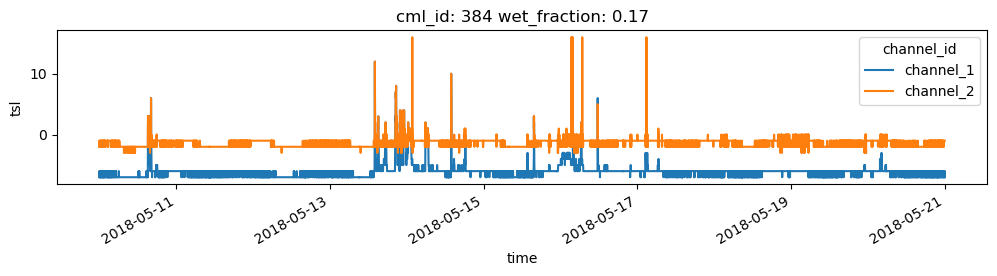

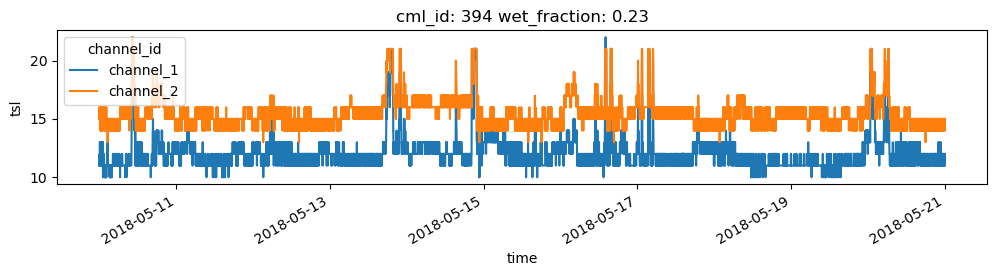

In [35]:
std_threshold_lower = 1.35 
std_threshold_upper = 2
for cml in cml_list:
    if ((cml.tsl_std > std_threshold_lower) & (cml.tsl_std > std_threshold_upper)):
        cml.tsl.plot.line(x='time', figsize=(12,2))
        # plt.gca().set_prop_cycle(rollcycler(2))
        # cml.nrsl.plot.line(x='time', figsize=(12,2))
        plt.title(f'cml_id: {cml.cml_id.values} wet_fraction: {cml.wet_fraction.values:0.2f}')
        plt.show()

# Compare derived rain rates with reference data
As reference, path-averaged rain rates along the CMLs paths from RADKLIM-YW are provided. This data has a temporal resolution of 5 minutes. First, we compare one CML timeseries aggregated to five minutes individually against its reference timeseries. Then we resample all cml data und prepare a scatterplot between CML and reference data. Finally some metrics are claculated. (for simplicity only `channel 1` is evaluated here)

In [36]:
path_ref = xr.open_dataset(data_path + '/example_path_averaged_reference_data.nc')

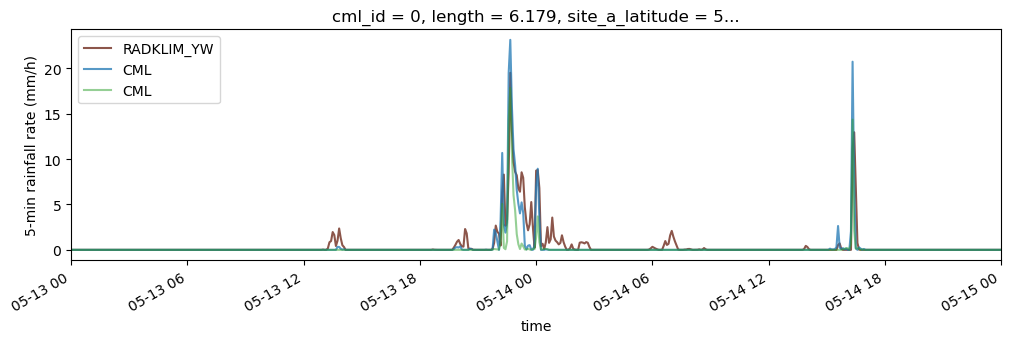

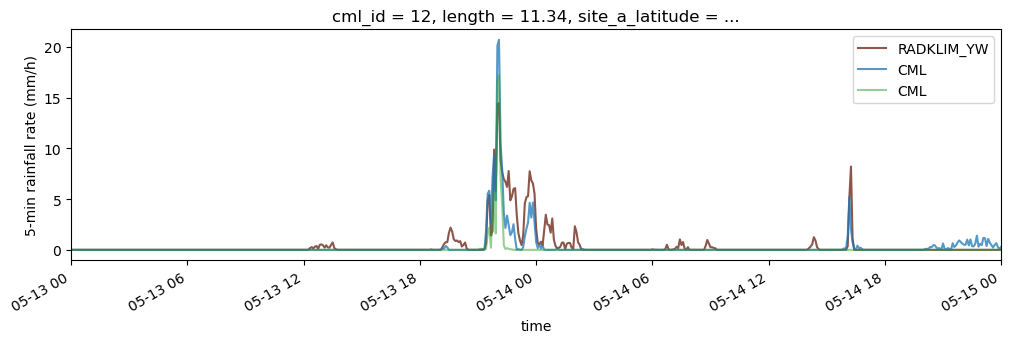

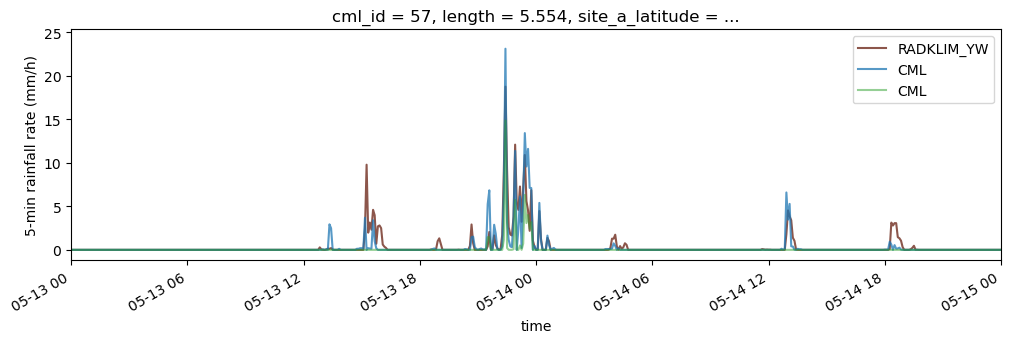

In [37]:
for i in [0, 12, 57]:
    # Plot reference rainfall amount (converted to 5-minute rainfall rate)
    (path_ref.sel(cml_id=cml_abbrev_list[i].cml_id).rainfall_amount * 12).plot(
        label="RADKLIM_YW", color='C5', figsize=(12,3)
    )
    # Plot 5-minute mean rainfall rates from CMLs
    (cml_abbrev_list[i].sel(channel_id="channel_1").R.resample(time="5min").mean()).plot(
        x="time", label="CML", color='C0', alpha=0.75
    )
    # Plot 5-minute mean rainfall rates from CMLs
    (cml_abbrev_list[i].sel(channel_id="channel_1").R_rsl.resample(time="5min").mean()).plot(
        x="time", label="CML", color='C2', alpha=0.5
    )
    
    plt.xlim(pd.to_datetime('2018-05-13'), pd.to_datetime('2018-05-15'))
    plt.ylabel('5-min rainfall rate (mm/h)')
    plt.legend();

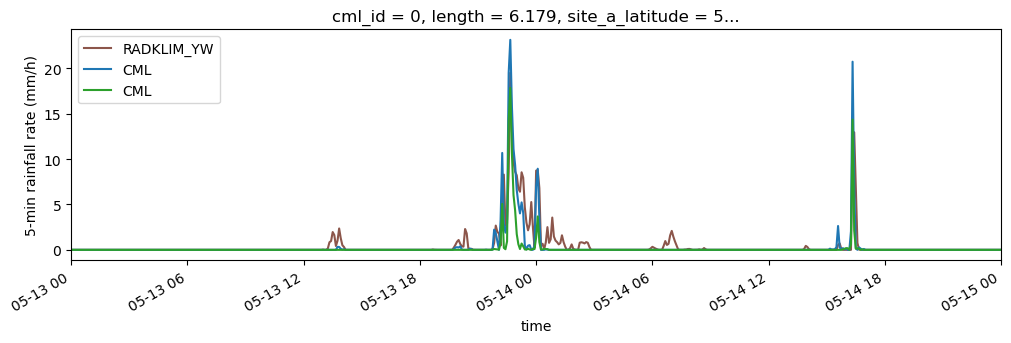

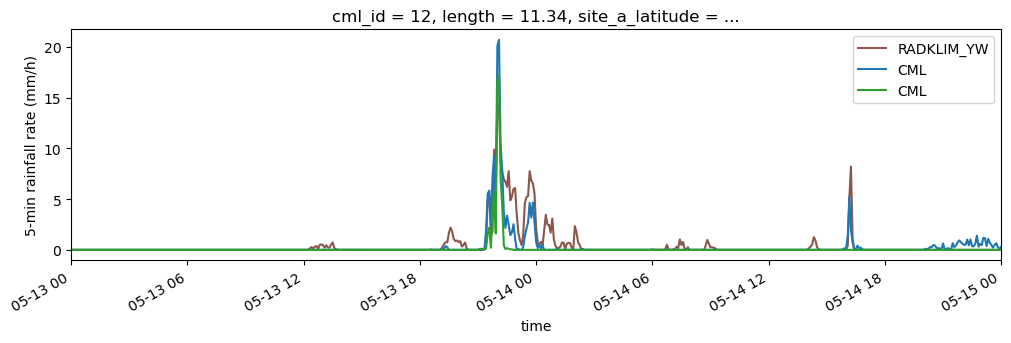

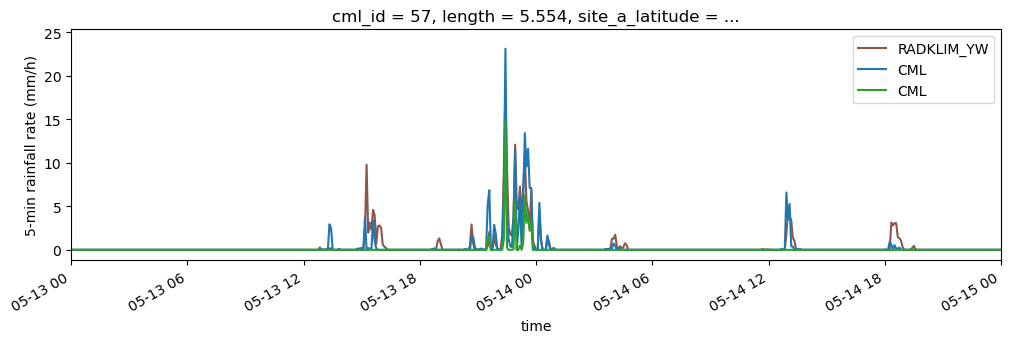

In [38]:
for i in [0, 12, 57]:
    # Plot reference rainfall amount (converted to 5-minute rainfall rate)
    (path_ref.sel(cml_id=cml_abbrev_list[i].cml_id).rainfall_amount * 12).plot(
        label="RADKLIM_YW", color='C5', figsize=(12,3)
    )
    # Plot 5-minute mean rainfall rates from CMLs
    (cml_abbrev_list[i].sel(channel_id="channel_1").R.resample(time="5min").mean()).plot(
        x="time", label="CML", color='C0'
    )
    # Plot 5-minute mean rainfall rates from CMLs
    (cml_abbrev_list[i].sel(channel_id="channel_1").R_rsl.resample(time="5min").mean()).plot(
        x="time", label="CML", color='C2'
    )
    
    plt.xlim(pd.to_datetime('2018-05-13'), pd.to_datetime('2018-05-15'))
    plt.ylabel('5-min rainfall rate (mm/h)')
    plt.legend();

Aggregate the CML data to 5 minute rainfall sums and concat the indiviudal CML `xarray.Dataset`s to one joint `xarray.Dataset` for the comparison with the reference.

In [39]:
ds_cmls = xr.concat(cml_list, dim='cml_id')

In [40]:
rainsum_5min = ds_cmls.sel(channel_id="channel_1").R.resample(time="5min").sum() / 60
rainsum_5min_RSL = ds_cmls.sel(channel_id="channel_1").R_rsl.resample(time="5min").sum() / 60


C:\Users\acuddeback\AppData\Local\Temp\1\ipykernel_19700\931693490.py:4: RuntimeWarning: Mean of empty slice
  percent_error = np.nanmean(np.where(np.isinf(percent_error), np.nan, percent_error),1)


(500,)
Distribution of Mean 5-minute Rainfall Estimate Error Relative to Calculation with TSL


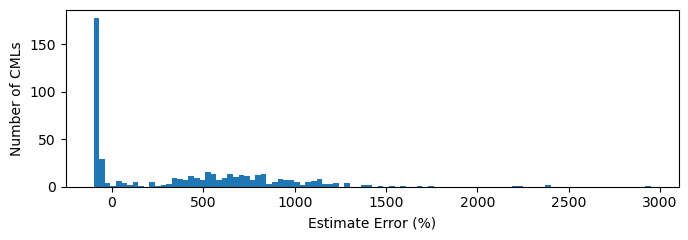

In [41]:
percent_error = 100*((rainsum_5min_RSL - rainsum_5min) / rainsum_5min)

# Replace infinite values with NaN
percent_error = np.nanmean(np.where(np.isinf(percent_error), np.nan, percent_error),1)

# print(len(percent_error))
print(percent_error.shape)


plt.figure(figsize=(7,2.5))
plt.hist(percent_error[~np.isnan(percent_error)], bins=100)  # Exclude NaN values from histogram
plt.xlabel("Estimate Error (%)")
plt.ylabel("Number of CMLs")
titlestr = "Distribution of Mean 5-minute Rainfall Estimate Error Relative to Calculation with TSL"
print(titlestr)
# plt.title(titlestr)

 
plt.tight_layout()

 #plt.savefig("./Figures/Hist_pcterr.png", bbox_inches='tight')
plt.show()

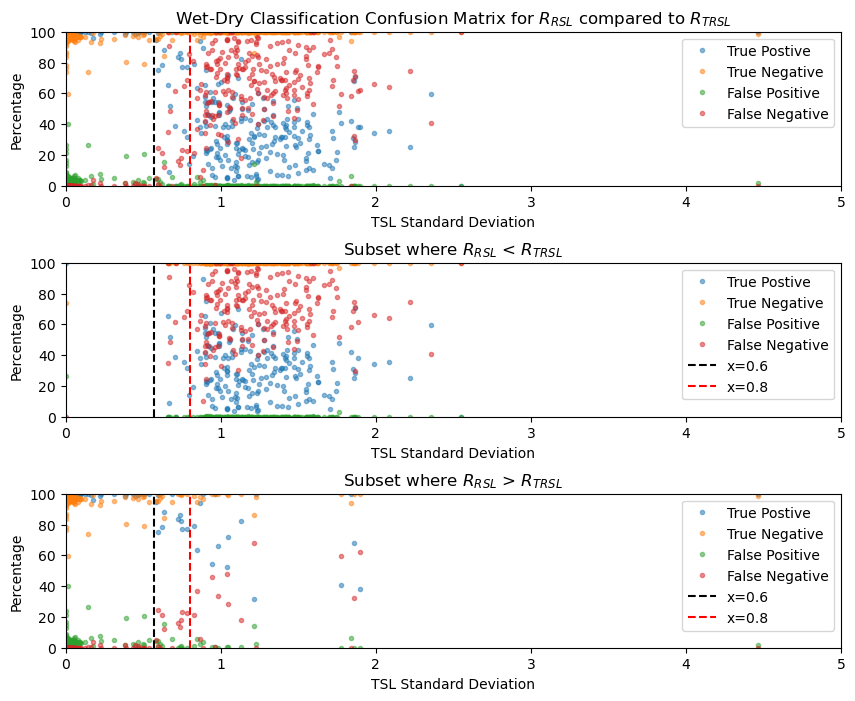

In [42]:

# positive error 
sorted_indices = np.argsort(std_and_conf[:, 0])
sorted_std_and_conf = std_and_conf[sorted_indices]

plt.figure(figsize=(10, 8))
tsl_std_cutoff = 0.57

plt.subplot(311)
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,4],'.', alpha=0.5)
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,1],'.', alpha=0.5)
plt.ylim([0,100])
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,2],'.', alpha=0.5)
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,3],'.', alpha=0.5)

plt.axvline(x=tsl_std_cutoff, color='black', linestyle='--')
plt.axvline(x=0.8, color='red', linestyle='--')

plt.xlim([0,5])
plt.legend(["True Postive", "True Negative", "False Positive", "False Negative"])
plt.ylabel("Percentage")
plt.xlabel("TSL Standard Deviation")
plt.title('Wet-Dry Classification Confusion Matrix for $R_{RSL}$ compared to $R_{TRSL}$')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)



# negative error 
neg_std_and_conf = std_and_conf[(percent_error < 0).T,:]
sorted_indices = np.argsort(neg_std_and_conf[:, 0])
sorted_std_and_conf = neg_std_and_conf[sorted_indices]

plt.subplot(312)
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,4],'.',alpha=0.5)
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,1],'.',alpha=0.5)
plt.ylim([0,100])
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,2],'.',alpha=0.5)
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,3],'.',alpha=0.5)

# Add dashed vertical line at x=0.75
plt.axvline(x=tsl_std_cutoff, color='black', linestyle='--')
plt.axvline(x=0.8, color='red', linestyle='--')
plt.xlim([0,5])
plt.legend(["True Postive", "True Negative", "False Positive", "False Negative","x=0.6", "x=0.8"])
plt.ylabel("Percentage")
plt.xlabel("TSL Standard Deviation")
plt.title('Subset where $R_{RSL}$ < $R_{TRSL}$')

# positive error 
pos_std_and_conf = std_and_conf[(percent_error > 0).T,:]
sorted_indices = np.argsort(pos_std_and_conf[:, 0])
sorted_std_and_conf = pos_std_and_conf[sorted_indices]

plt.subplot(313)
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,4],'.',alpha=0.5)
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,1],'.',alpha=0.5)
plt.ylim([0,100])
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,2],'.',alpha=0.5)
plt.plot(sorted_std_and_conf[:,0], sorted_std_and_conf[:,3],'.',alpha=0.5)
# Add dashed vertical line at x=0.75
plt.axvline(x=tsl_std_cutoff, color='black', linestyle='--')
plt.axvline(x=0.8, color='red', linestyle='--')

plt.xlim([0,5])
plt.legend(["True Postive", "True Negative", "False Positive", "False Negative", "x=0.6", "x=0.8"])
plt.ylabel("Percentage")
plt.xlabel("TSL Standard Deviation")
plt.title('Subset where $R_{RSL}$ > $R_{TRSL}$')


 #plt.savefig("./Figures/wet-dry_confusion.png")
plt.show()


## TSL Standard Deviation and Error 


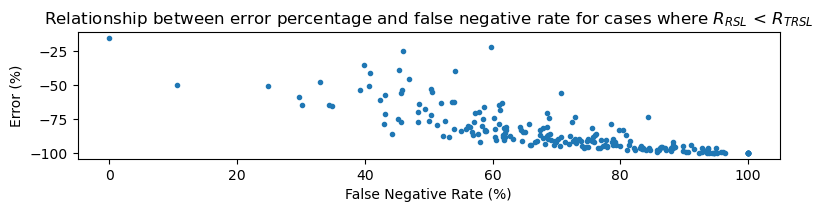

In [43]:
plt.figure(figsize=(8,2))
plt.plot(std_and_conf[percent_error<0,3],percent_error[percent_error<0],'.')
plt.xlabel("False Negative Rate (%)")
plt.ylabel("Error (%)")
titlestr='Relationship between error percentage and false negative rate for cases where $R_{RSL}$ < $R_{TRSL}$'
 
plt.tight_layout()
 #plt.savefig("./Figures/error_vs_false_neg_rate_rsl_lt_trsl.png")
plt.title(titlestr)
plt.show()

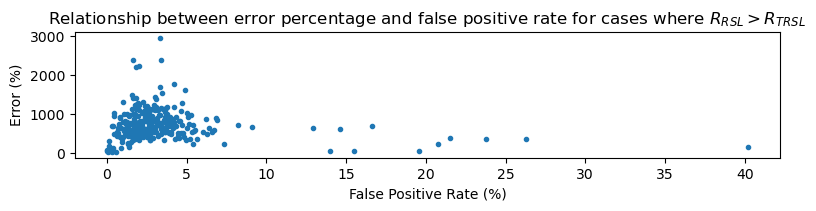

In [44]:
plt.figure(figsize=(8,2))
plt.plot(std_and_conf[percent_error>0,2],percent_error[percent_error>0],'.')
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Error (%)")
titlestr='Relationship between error percentage and false positive rate for cases where $R_{RSL} > R_{TRSL}$'
 
plt.tight_layout()
 #plt.savefig("./Figures/error_vs_false_pos_rate_rsl_lt_trsl.png")
plt.title(titlestr)
plt.show()

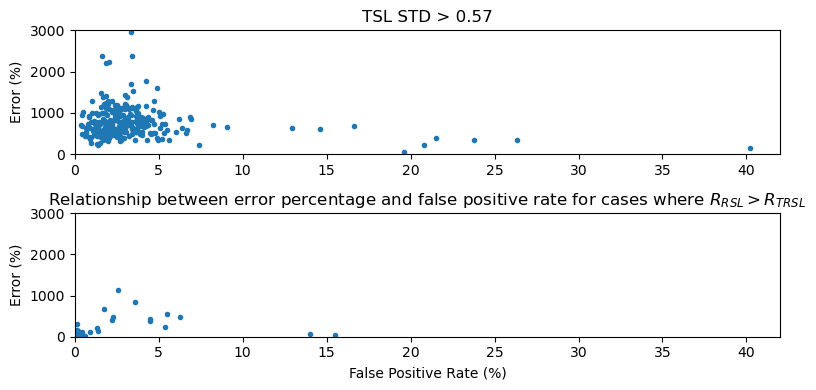

In [45]:
plt.figure(figsize=(8,4))
plt.subplot(211)
all_tsl_std = std_and_conf[:,0]
plt.plot(std_and_conf[(percent_error > 0) & (all_tsl_std<0.57),2], percent_error[(percent_error > 0) & (all_tsl_std<0.57)],'.')
plt.title("TSL STD > 0.57")
# plt.xlabel("False Positive Rate (%)")
plt.ylabel("Error (%)")
plt.ylim([0,3000])
plt.xlim([0,42])

plt.subplot(212)
all_tsl_std = std_and_conf[:,0]
plt.plot(std_and_conf[(percent_error > 0) & (all_tsl_std>0.57),2], percent_error[(percent_error > 0) & (all_tsl_std>0.57)],'.')
plt.title("TSL STD < 0.57")
# plt.xlabel("False Positive Rate (%)")
# plt.ylabel("Error (%)")
# plt.ylim([0,3000])
# plt.xlim([0,42])

# plt.subplot(313)
# all_tsl_std = std_and_conf[:,0]
# plt.plot(std_and_conf[(percent_error > 0) & (all_tsl_std>0.8),2], percent_error[(percent_error > 0) & (all_tsl_std>0.8)],'.')
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Error (%)")
plt.ylim([0,3000])
plt.xlim([0,42])

titlestr='Relationship between error percentage and false positive rate for cases where $R_{RSL} > R_{TRSL}$'
 
plt.tight_layout()
 #plt.savefig("./Figures/error_vs_false_pos_rate_rsl_lt_trsl.png")
plt.title(titlestr)
plt.show()

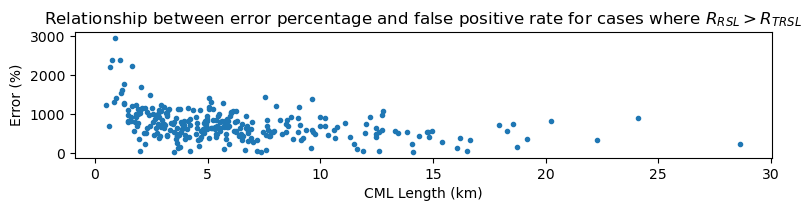

In [46]:
cml_lengths = cmls['length'].values

plt.figure(figsize=(8,2))
plt.plot(cml_lengths[percent_error>0],percent_error[percent_error>0],'.')
plt.xlabel("CML Length (km)")
plt.ylabel("Error (%)")
titlestr='Relationship between error percentage and false positive rate for cases where $R_{RSL} > R_{TRSL}$'
 
plt.tight_layout()
 #plt.savefig("./Figures/error_vs_length_rsl_lt_trsl.png")
plt.title(titlestr)
plt.show()

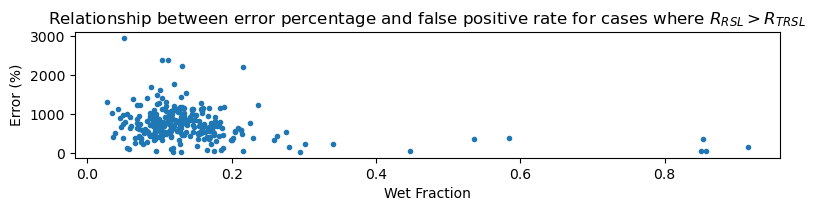

In [47]:
# wet_fractions = cml_list.wet_fraction.values[0]
wet_fractions = np.zeros((500,1))
for cml,i in zip(cml_list,range(500)):
    wet_fractions[i] = cml.wet_fraction

plt.figure(figsize=(8,2))
plt.plot(wet_fractions[percent_error>0],percent_error[percent_error>0],'.')
plt.xlabel("Wet Fraction")
plt.ylabel("Error (%)")
titlestr='Relationship between error percentage and false positive rate for cases where $R_{RSL} > R_{TRSL}$'
 
plt.tight_layout()
 #plt.savefig("./Figures/error_vs_wet_frac_rsl_lt_trsl.png")
plt.title(titlestr)
plt.show()

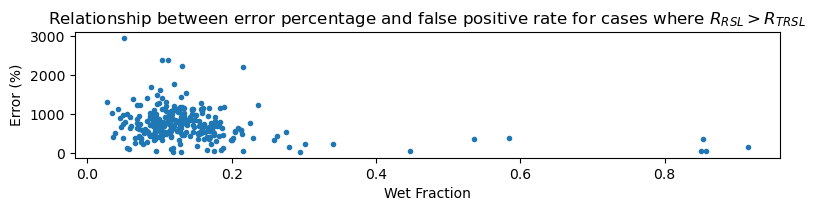

In [48]:
# wet_fractions = cml_list.wet_fraction.values[0]
wet_fractions = np.zeros((500,1))
for cml,i in zip(cml_list,range(500)):
    wet_fractions[i] = cml.wet_fraction

plt.figure(figsize=(8,2))
plt.plot(wet_fractions[percent_error>0],percent_error[percent_error>0],'.')
plt.xlabel("Wet Fraction")
plt.ylabel("Error (%)")
titlestr='Relationship between error percentage and false positive rate for cases where $R_{RSL} > R_{TRSL}$'
plt.tight_layout()
 #plt.savefig("./Figures/error_vs_wet_frac_rsl_lt_trsl.png")
plt.title(titlestr)
plt.show()

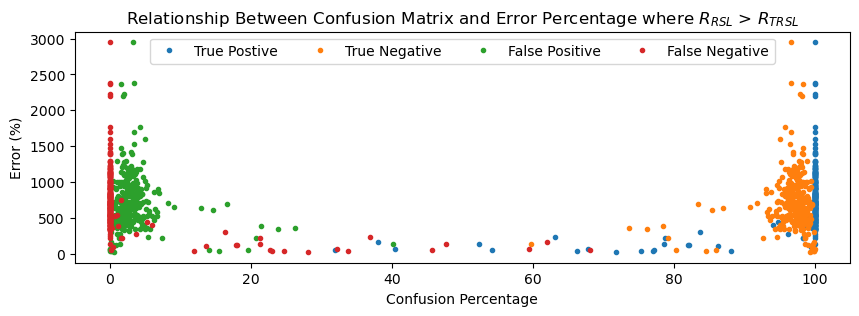

In [49]:

plt.figure(figsize=(10,3))
plt.plot(pos_std_and_conf[:,4], percent_error[percent_error>0],'.')
plt.plot(pos_std_and_conf[:,1], percent_error[percent_error>0],'.')
plt.plot(pos_std_and_conf[:,2], percent_error[percent_error>0],'.')
plt.plot(pos_std_and_conf[:,3], percent_error[percent_error>0],'.')
plt.legend(["True Postive", "True Negative", "False Positive", "False Negative"], loc="upper center",ncol=4)
plt.xlabel("Confusion Percentage")
plt.ylabel("Error (%)")
 #plt.savefig("./Figures/error_vs_conf.png")
plt.title('Relationship Between Confusion Matrix and Error Percentage where $R_{RSL}$ > $R_{TRSL}$')
plt.show()

# Compare Results of CML Estimates to RADAR

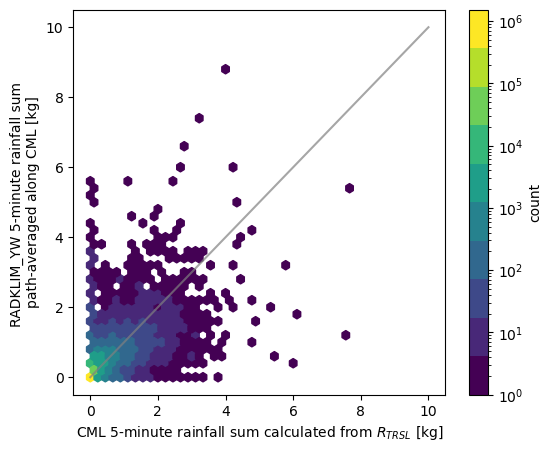

In [50]:
# rainsum_5min = ds_cmls.sel(channel_id="channel_1").R.resample(time="5min").sum() / 60

fig, ax = plt.subplots(figsize=(6, 5))
hx = ax.hexbin(
    rainsum_5min.values.T.flatten(),
    path_ref.rainfall_amount.values.flatten(),
    mincnt=1,
    bins="log",
    gridsize=45,
    extent=(0, 10, 0, 10),
    cmap=plt.get_cmap('viridis', 10),
)
ax.plot([0, 10], [0, 10], color='gray', alpha=0.7)
ax.set_xlabel('CML 5-minute rainfall sum calculated from $R_{TRSL}$ [kg]');
ax.set_ylabel('RADKLIM_YW 5-minute rainfall sum \npath-averaged along CML [kg]');
cbar = fig.colorbar(hx)
cbar.set_label('count')
 #plt.savefig('cml_rad_vs_trsl.png')
plt.show()

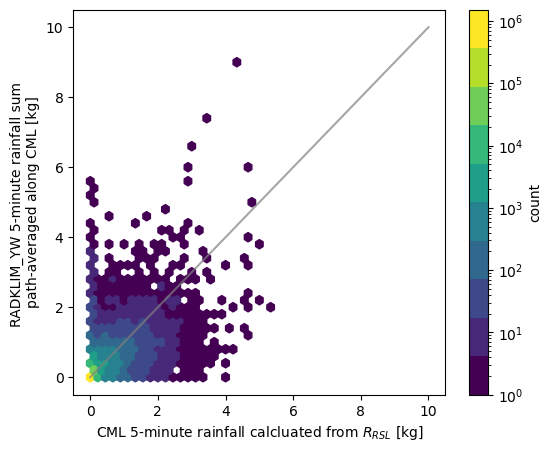

In [51]:
# rainsum_5min = ds_cmls.sel(channel_id="channel_1").R.resample(time="5min").sum() / 60
# rainsum_5min_RSL = ds_cmls.sel(channel_id="channel_1").R_rsl.resample(time="5min").sum() / 60

fig, ax = plt.subplots(figsize=(6, 5))
hx = ax.hexbin(
    rainsum_5min_RSL.values.T.flatten(),
    path_ref.rainfall_amount.values.flatten(),
    mincnt=1,
    bins="log",
    gridsize=45,
    extent=(0, 10, 0, 10),
    cmap=plt.get_cmap('viridis', 10),
)
ax.plot([0, 10], [0, 10], color='gray', alpha=0.7)
ax.set_xlabel('CML 5-minute rainfall calcluated from $R_{RSL}$ [kg]');
ax.set_ylabel('RADKLIM_YW 5-minute rainfall sum \npath-averaged along CML [kg]');
cbar = fig.colorbar(hx)
cbar.set_label('count')
 #plt.savefig('cml_rad_vs_nrsl.png')
plt.show()

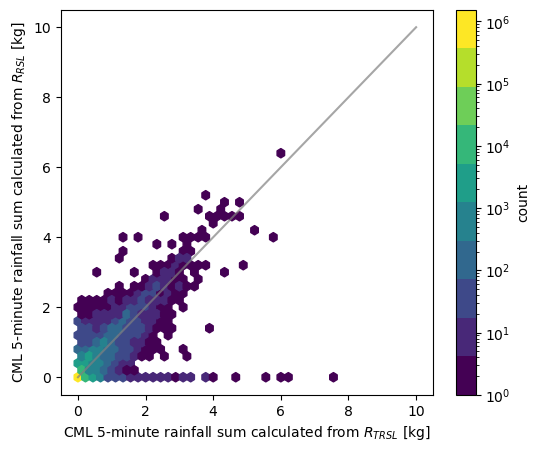

In [52]:
fig, ax = plt.subplots(figsize=(6, 5))
hx = ax.hexbin(
    rainsum_5min.values.T.flatten(),
    rainsum_5min_RSL.values.T.flatten(),
    mincnt=1,
    bins="log",
    gridsize=45,
    extent=(0, 10, 0, 10),
    cmap=plt.get_cmap('viridis', 10),
)
ax.plot([0, 10], [0, 10], color='gray', alpha=0.7)
ax.set_ylabel('CML 5-minute rainfall sum calculated from $R_{RSL}$ [kg]');
ax.set_xlabel('CML 5-minute rainfall sum calculated from $R_{TRSL}$ [kg]');
cbar = fig.colorbar(hx)
cbar.set_label('count')

 #plt.savefig('cml_nrsl_vs_trsl.png')
plt.show()

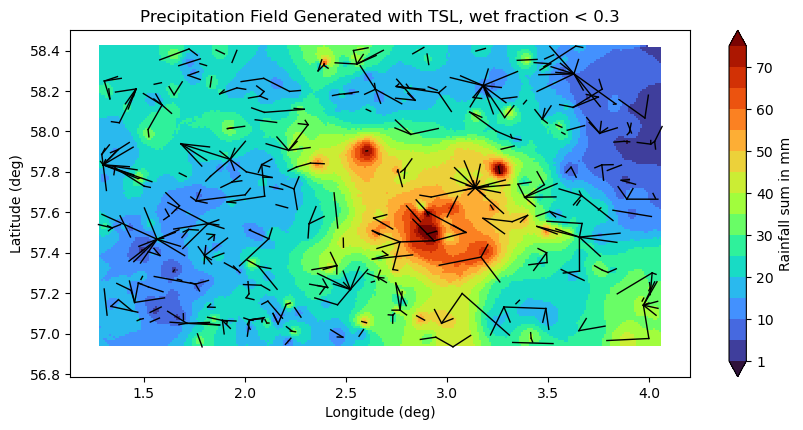

In [53]:
cmls_R_1h = ds_cmls.R.resample(time='1h', label='right').mean().to_dataset()

cmls_R_1h['lat_center'] = (cmls_R_1h.site_a_latitude + cmls_R_1h.site_b_latitude)/2
cmls_R_1h['lon_center'] = (cmls_R_1h.site_a_longitude + cmls_R_1h.site_b_longitude)/2
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.3,
)
def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_a_longitude, ds_cmls.site_b_longitude],
        [ds_cmls.site_a_latitude, ds_cmls.site_b_latitude],
        'k',
        linewidth=1,
    )

cmls_R_1h = ds_cmls.R.resample(time='1h', label='right').mean().to_dataset()
cmls_R_1h['lat_center'] = (cmls_R_1h.site_a_latitude + cmls_R_1h.site_b_latitude)/2
cmls_R_1h['lon_center'] = (cmls_R_1h.site_a_longitude + cmls_R_1h.site_b_longitude)/2

tsl_wet_fraction = 0.3

R_grid = idw_interpolator(
    x=cmls_R_1h.lon_center, 
    y=cmls_R_1h.lat_center, 
    z=cmls_R_1h.R.isel(channel_id=1).sum(dim='time').where(ds_cmls.wet_fraction < tsl_wet_fraction), 
    resolution=0.01,
)

bounds = np.arange(0, 80, 5.0)
bounds[0] = 1
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

fig, ax = plt.subplots(figsize=(10,4.5))
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    R_grid, 
    shading='nearest', 
    cmap='turbo',
    norm=norm,
)
plt.axis('equal')
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plot_cml_lines(cmls_R_1h, ax=ax)
fig.colorbar(pc, label='Rainfall sum in mm');
titlestr = f'Precipitation Field Generated with TSL, wet fraction < {tsl_wet_fraction}'
savestr = './PrecipFields/precipfield_tsl_wetfrac' + str(tsl_wet_fraction) +'.png'
plt.title(titlestr)
 #plt.savefig(savestr)
plt.show()

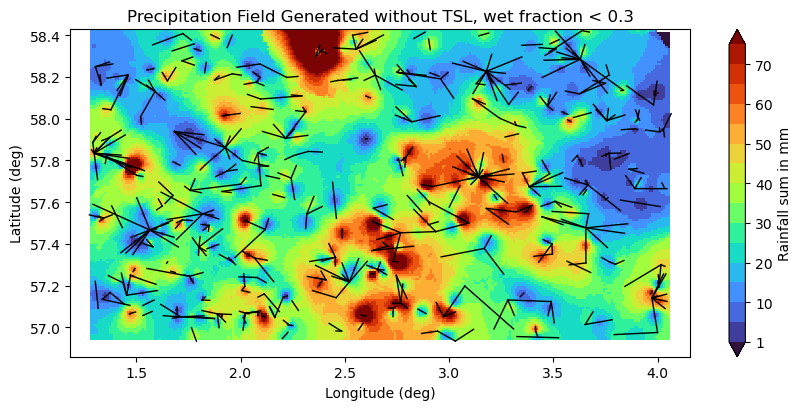

In [54]:
cmls_Rrsl_1h = ds_cmls.R_rsl.resample(time='1h', label='right').mean().to_dataset()
cmls_Rrsl_1h['lat_center'] = (cmls_Rrsl_1h.site_a_latitude + cmls_Rrsl_1h.site_b_latitude)/2
cmls_Rrsl_1h['lon_center'] = (cmls_Rrsl_1h.site_a_longitude + cmls_Rrsl_1h.site_b_longitude)/2
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.3,
)

def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_a_longitude, ds_cmls.site_b_longitude],
        [ds_cmls.site_a_latitude, ds_cmls.site_b_latitude],
        'k',
        linewidth=1,
    )

rsl_wet_fraction = 0.3
Rrsl_grid = idw_interpolator(
    x=cmls_Rrsl_1h.lon_center, 
    y=cmls_Rrsl_1h.lat_center, 
    z=cmls_Rrsl_1h.R_rsl.isel(channel_id=1).sum(dim='time').where(ds_cmls.wet_fraction < rsl_wet_fraction), 
    resolution=0.01,
)

bounds = np.arange(0, 80, 5.0)
bounds[0] = 1
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

fig, ax = plt.subplots(figsize=(10, 4.25))
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    Rrsl_grid, 
    shading='nearest', 
    cmap='turbo',
    norm=norm,
)
plot_cml_lines(cmls_Rrsl_1h, ax=ax)
plt.axis('equal')
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
fig.colorbar(pc, label='Rainfall sum in mm');
titlestr = f'Precipitation Field Generated without TSL, wet fraction < {rsl_wet_fraction}'
savestr = './PrecipFields/precipfield_rsl_wetfrac' + str(rsl_wet_fraction) +'.png'
 #plt.savefig(savestr)
plt.title(titlestr)
plt.show()

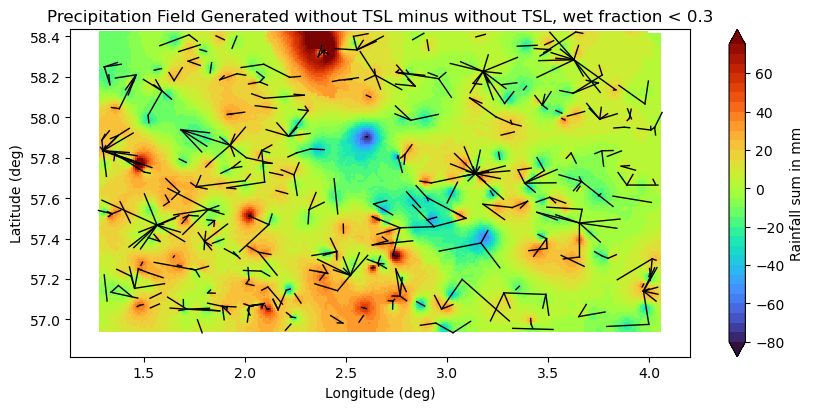

In [55]:
def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_a_longitude, ds_cmls.site_b_longitude],
        [ds_cmls.site_a_latitude, ds_cmls.site_b_latitude],
        'k',
        linewidth=1,
    )

rsl_wet_fraction = 0.3
Rdif_grid = idw_interpolator(
    x=cmls_Rrsl_1h.lon_center, 
    y=cmls_Rrsl_1h.lat_center, 
    z=-cmls_R_1h.R.isel(channel_id=1).sum(dim='time').where(ds_cmls.wet_fraction < tsl_wet_fraction)+cmls_Rrsl_1h.R_rsl.isel(channel_id=1).sum(dim='time').where(ds_cmls.wet_fraction < tsl_wet_fraction), 
    resolution=0.01,
)
bounds = np.arange(-80, 80, 5.0)
# bounds[0] = 1
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

fig, ax = plt.subplots(figsize=(10,4.25))
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    Rdif_grid, 
    shading='nearest', 
    cmap='turbo',
    norm=norm,
)
plot_cml_lines(cmls_Rrsl_1h, ax=ax)
plt.axis('equal')
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.ylim([56.75, 58.5])
fig.colorbar(pc, label='Rainfall sum in mm');
titlestr = f'Precipitation Field Generated without TSL minus without TSL, wet fraction < {rsl_wet_fraction}'
savestr = './PrecipFields/diff_precip_' + str(tsl_wet_fraction) +'wetfrac.png'
 #plt.savefig(savestr)
plt.title(titlestr)
plt.show()